In [7]:
import sys
import os
# sys.path.append(os.path.abspath("..")) 
sys.path.append("fypv3") 
import importlib
# import src

In [11]:
import src

In [8]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.cm as cm


import math
from IPython.display import display
import yfinance as yf

import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F


In [13]:
import src.models

In [14]:
# import src
try: 
    for module in [src.models, src.data, src.utils, src.train, src.verification, src.visualisation, src.evaluation]:
        if module:
            importlib.reload(module)
    print("Reloading")
except Exception as e:
    # raise e
    print("Not reloading")

from src.models import *
from src.data import *
from src.utils import *
from src.train import *
from src.verification import *
from src.visualisation import *
from src.evaluation import *

Not reloading


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
trainval_start = "2006-04-02"
trainval_end = "2019-12-31"
test_start = "2020-01-01"
# test_start = "2020-01-01"
test_end = "2022-12-31"

trainval_end = (pd.to_datetime(trainval_end) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")
test_start = (pd.to_datetime(test_start) - pd.tseries.offsets.BDay(53)).strftime("%Y-%m-%d")

In [17]:
returns_df, close_df =  get_asset_dataset(trainval_start, test_end)

asset_names = list(returns_df.columns)
n_assets = len(asset_names)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [18]:
trainval_mask = (close_df.index >= trainval_start) & (close_df.index <= trainval_end)
trainval_indices = close_df[trainval_mask].index

val_size = int(0.20 * len(trainval_indices))
train_indices = trainval_indices[:-val_size]
val_indices = trainval_indices[-val_size:]

test_mask = (close_df.index >= test_start) & (close_df.index <= test_end)
test_indices = close_df[test_mask].index

/tmp/ipykernel_1424801/1400509521.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


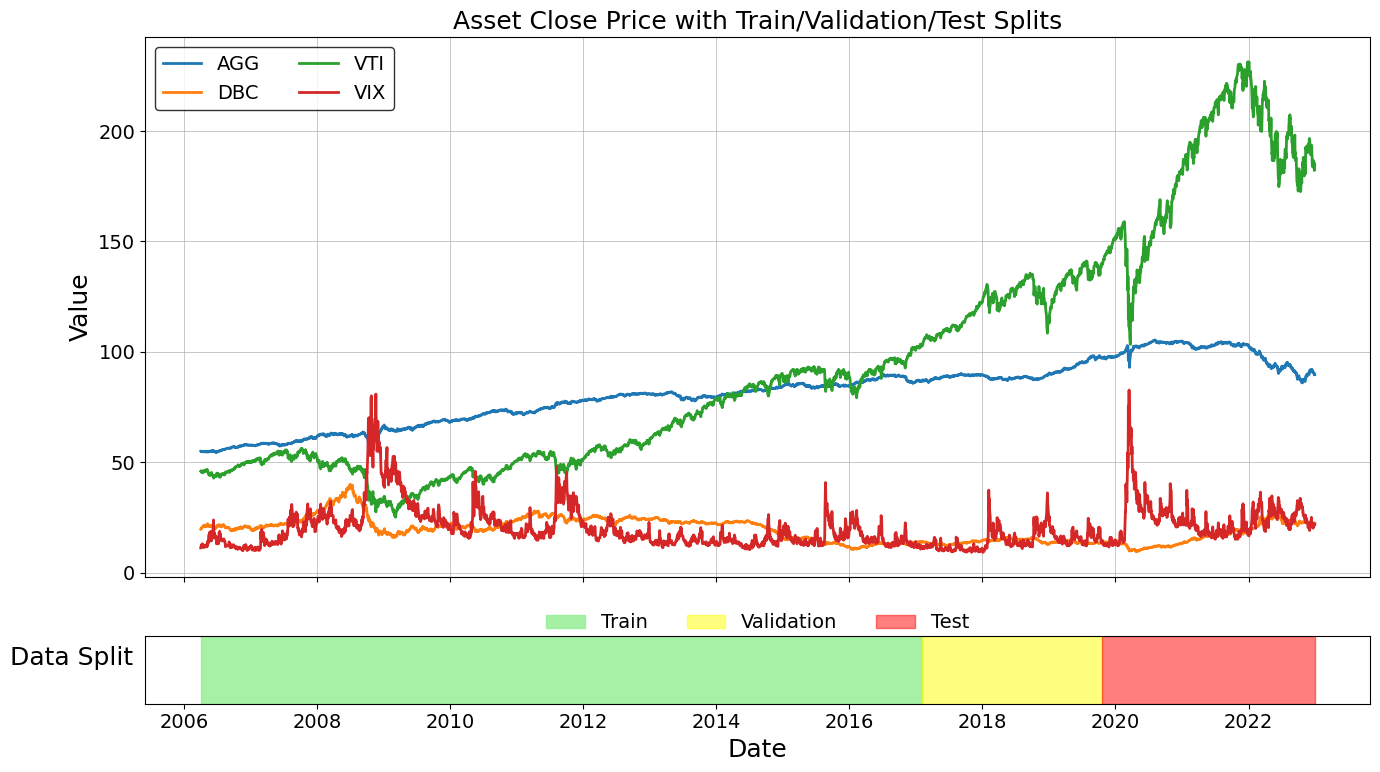

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
colors = cm.get_cmap('tab10')

# -----------------------------------------------------------------------------
# ASSUMPTIONS:
#  - `close_df` is a pandas.DataFrame with a datetime-like index,
#    and columns corresponding to each ticker/asset.
#  - `train_indices`, `val_indices`, `test_indices` are each lists/arrays of
#    datetime-like index labels (e.g. pandas Timestamp) in `close_df.index` that define the three splits.
#  - `colors` is a colormap or function such that `colors(i)` returns a distinct color for asset i.
# -----------------------------------------------------------------------------

# Increase default font sizes for PDF readability
plt.rcParams.update({
    "font.size": 16,            # base font size for labels, ticks, legend text
    "axes.titlesize": 18,       # title font size
    "axes.labelsize": 18,       # x/y axis label font size
    "xtick.labelsize": 14,      # x-axis tick label font size
    "ytick.labelsize": 14,      # y-axis tick label font size
    "legend.fontsize": 14,      # legend text font size
})

# Compute start and end dates for each split
train_start = min(train_indices)
train_end = max(train_indices)
val_start = min(val_indices)
val_end = max(val_indices)
test_start = min(test_indices)
test_end = max(test_indices)

# Create subplots: main plot on top, timeline on bottom
fig, (ax_main, ax_timeline) = plt.subplots(
    2, 1, sharex=True,
    gridspec_kw={'height_ratios': [8, 1]},
    figsize=(14, 8)
)

# 1) Plot each asset on the main axes
for i, ticker in enumerate(close_df.columns):
    asset_color = colors(i)
    # Plot Train, Validation, Test segments: only label Train for legend
    for idx, label in zip([train_indices, val_indices, test_indices], ["Train", "Val", "Test"]):
        plot_label = ticker if label == "Train" else "_nolegend_"
        ax_main.plot(
            close_df.loc[idx, ticker],
            color=asset_color,
            linewidth=2,
            label=plot_label
        )

ax_main.set_title("Asset Close Price with Train/Validation/Test Splits")
ax_main.set_ylabel("Value")
ax_main.grid(True, linewidth=0.5)
ax_main.legend(loc="upper left", fontsize="14", ncol=2, frameon=True, edgecolor="black")

# 2) Create the timeline: colored boxes for each split
#    We'll use ax_timeline.axvspan to draw colored regions at y=[0, 1] for each split.
ax_timeline.axvspan(train_start, train_end, color="lightgreen", alpha=0.8, label="Train")
ax_timeline.axvspan(val_start, val_end, color="yellow", alpha=0.5, label="Validation")
ax_timeline.axvspan(test_start, test_end, color="red", alpha=0.5, label="Test")

# Remove y-axis details for timeline
ax_timeline.set_yticks([])
ax_timeline.set_ylabel("Data Split", rotation=0, labelpad=40)
ax_timeline.yaxis.set_label_coords(-0.06, 0.5)
ax_timeline.grid(False)

# Format x-axis as dates
ax_timeline.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_timeline.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

# Add legend for the timeline in the timeline subplot
ax_timeline.legend(loc="center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.2))

plt.xlabel("Date")
plt.tight_layout(h_pad=1.0)
plt.show()


In [20]:
lookback = 50   
horizon = 5     
allocation_step = 5

X_train, y_train, train_idx = create_windows(returns_df, train_indices, lookback, horizon)
X_val, y_val, val_idx = create_windows(returns_df, val_indices, lookback, horizon)
X_test, y_test, test_idx = create_windows(returns_df, test_indices, lookback, horizon)

batch_size = 28

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

num_samples, seq_len, num_assets = X_train_tensor.shape
flattened = X_train_tensor.reshape(-1, num_assets)

mean = flattened.mean(dim=0)  # shape (num_assets,)
std = flattened.std(dim=0)    # shape (num_assets,)

std[std == 0] = 1.0

X_train_tensor = standardize(X_train_tensor, mean, std)
X_val_tensor = standardize(X_val_tensor, mean, std)
X_test_tensor = standardize(X_test_tensor, mean, std)

saved_mean = mean
saved_std = std

In [21]:
# asset_std = X_train_tensor.reshape(-1, X_train_tensor.shape[-1]).std(dim=0)
sigma = 0.025
jitter = Jitter(sigma=sigma)

train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Experiments

In [22]:
def run_experiment(model, data, experiment={}):
    params = experiment.get("params", {})
    rebalance_freq = params.get("rebalance_freq", 252)
    x, y = data
    model.eval()
    n = y.shape[0]

    x = x.to(device)

    portfolio_values,weights,holdings = get_portfiolio_value(model, (x,y), rebalance_freq)

    weights = torch.tensor(weights).squeeze(1)
    holdings = torch.tensor(holdings).squeeze(1)


    # returns = portfolio_values.
    cum_returns = portfolio_values - 1

    returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]

    # Daily metrics
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe = sharpe_ratio(returns)

    metrics = {
        "expected_return": cum_returns[-1].item(),
        "sharpe_ratio": sharpe,
        "max_drawdown": max_drawdown(portfolio_values),
        "mean_entropy": mean_entropy(weights),
        "mean_return": mean_return,
        "std_return": std_return,
    }

    raw = {
        "weights": weights,
        "returns": returns,
        "cum_returns": cum_returns,
        "holdings": holdings,
    }

    return {"metrics": metrics, "raw": raw}




In [23]:
def default_linestyle_map(params):
    return "-"

def display_train_results(experiments):
    plt.figure(figsize=(10, 6))
    colors = cm.get_cmap('tab10')

    for idx, (label, experiment) in enumerate(experiments.items()):
        if "train_results" not in experiment:
            continue
        # label = label_from_params(experiment["params"], experiments)
        
        data = experiment["train_results"]
        epochs = list(range(1, len(data["train_losses"]) + 1))
        color = colors(idx % 10) 

        plt.plot(epochs, data["train_losses"], label=f"{label} - Train", linestyle='-', color=color)
        plt.plot(epochs, data["val_losses"], label=f"{label} - Val", linestyle='--', color=color)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map=default_linestyle_map, label_from_params=None, additional_detail=False):
    metrics_df  = pd.DataFrame({k: v['results'][dataset_key]["metrics"] for k, v in experiments.items()}).T
    metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)
    display(metrics_df)

    plt.figure(figsize=(10, 6))
    for label, params, cr in [(k, v["params"], v['results'][dataset_key]["raw"]["cum_returns"]) for k, v in experiments.items()]:

        print(cr.shape)
        plt.plot(dataset_idx, cr, label=label, linestyle=linestyle_map(params))

    plt.title(f"Cumulative Returns of Different Models ({dataset_key.title()})")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ncols = 2
    nrows = math.ceil(len(experiments.items()) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
    axes = axes.flatten()

    # Loop through and plot
    for i, (label, weights) in enumerate([(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]):
        ax = axes[i]
        ax.stackplot(dataset_idx, weights.T.detach().numpy(), labels=asset_names)
        ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Proportion')
        ax.legend(loc='upper left')
        ax.grid(True)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    if additional_detail:

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * ncols, 5 * nrows))
        axes = axes.flatten()

        # Loop through and plot
        for i, (label, holding) in enumerate([(k, v['results'][dataset_key]["raw"]["holdings"]) for k, v in experiments.items()]):
            ax = axes[i]
            ax.plot(dataset_idx, holding.detach().numpy(), label=asset_names)
            ax.set_title(f'Stacked Area Plot of Asset Allocations ({label})')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Proportion')
            ax.legend(loc='upper left')
            ax.grid(True)

        # Hide any unused axes
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))

        for params, weights in [(k, v['results'][dataset_key]["raw"]["weights"]) for k, v in experiments.items()]:
            if "epochs" not in params:
                continue
            plt.plot(dataset_idx, entropy(weights).detach().numpy(), label=label)

        plt.axhline(np.log(n_assets), color='gray', linestyle='--', label='Max Entropy (Uniform)')
        plt.title(f'Allocation Entropy Over Time ({dataset_key.title()})')
        plt.xlabel('Date')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metrics_df    

# Robust
 Training

In [24]:
def loss_fn_fn(params):
    lambda_entropy = params["lambda_entropy"]
    def loss_fn(x, y, model):
        weights = model(x)

        asset_returns = ((1 + y).prod(1)-1)
        portfolio_returns = (asset_returns*weights).sum(1)
        natural_loss = -portfolio_returns.mean() 
        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
        return natural_loss -  entropy_loss
    return loss_fn 
    
def standard_model_fn(params):
    if params["model"] == "CNN":
        return CNNAllocatorCausal(4, lookback).to(device)
    elif params["model"] == "MLP":
        return SimpleAssetAllocationModel(4*lookback).to(device)
    elif params["model"] == "LSTM":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "LSTM_Unrolled":
        hidden_size = params["lstm_hidden_layers"]
        num_layers = params["lstm_hidden_layers"]
        return LSTM_Unrolled(n_assets, hidden_size, num_layers, n_assets).to(device)
    elif params["model"] == "Transformer":
        return Transformer(input_size=50,  output_size=4, d_model=2, nhead=2, num_layers=2, dim_head=4).to(device)

    raise Exception("Model not found")

In [25]:
def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":
        lambda_entropy = params["lambda_entropy"]
    
        def loss_fn(x, y, model):
            weights = model(x)


            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)

            natural_loss = -portfolio_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss -  entropy_loss
        return loss_fn 
    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps_vector = torch.tensor(e*robust_eps, dtype=torch.float32, device=device)
        

        def loss_fn(x, y, model):
            weights = model(x)

            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)
            worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)

            natural_loss = -portfolio_returns.mean() 
            robust_loss = -worst_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss * (1-alpha) + robust_loss * alpha + entropy_loss
        return loss_fn
    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = e*robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                output_adv
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn

## CNN 

In [26]:
# params_grids = [{
#     "seed": [1,2,3, 4, 5],
#     "epochs": [100],
#     "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
#     "model": ["CNN"],
#     "learning_rate": [1e-3],
#     "checkpoint_freq": [10],
#     "rebalance_freq": [5],
#     "jitter" : [1.5]
# }
# ]




# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     # experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [27]:
def hyperparam_search(experiments, metric="val_expected_return", over="seed"):
    params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
    # display(params_df)
    results_df = params_df
    for df_name in ["val", "test"]:
        df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
        df = df.add_prefix(f'{df_name}_')
        results_df = pd.concat([results_df, df], axis=1)

    metric = "val_expected_return"
    params = params_df.columns 
    group_by_params = [p for p in params if p!= over]
    agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})
    print("Hyperparam Search over seeds")
    display(agg_results_df)
    best_params = agg_results_df[group_by_params].iloc[0].to_dict()

    for col, val in best_params.items():
        results_df = results_df[results_df[col] == val]

    results_df = results_df.sort_values(metric, ascending=False)[params].iloc[0]
    return results_df.to_dict()


In [28]:
# best_params = best_CNN_params = hyperparam_search(experiments)
# filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
# display_train_results(filtered_experiements)
# for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## MLP - Param Tuning

In [29]:
# params_grids = [{
#     "seed": [1,2,3,4,5],
#     "epochs": [50],
#     "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
#     "model": ["MLP"],
#     "learning_rate": [1e-3],
#     "checkpoint_freq": [5],
#     "rebalance_freq": [5],
#     "jitter" : [1.5]
# }
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [30]:
# best_params = best_MLP_params = hyperparam_search(experiments)
# filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
# display_train_results(filtered_experiements)
# for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## LSTM Hyperparameter tuning

In [31]:
# params_grids = [{
#     "seed": [0, 20],
#     "epochs": [100],
#     "lambda_entropy": [0.025],
#     "model": ["LSTM"],
#     "lstm_layers" : [4],
#     "lstm_hidden_layers": [1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [8]
# }
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [32]:
# best_params = best_lstm_params = hyperparam_search(experiments)
# filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
# display_train_results(filtered_experiements)
# for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Transformer Hyperparameter tuning



In [33]:
# params_grids = [{
#     "seed": [0, 1, 2],
#     "epochs": [20],
#     "lambda_entropy": [0.025],
#     "model": ["Transformer"],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "checkpoint_freq": [3]
# }
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

In [34]:
# best_params = best_transformer_params = hyperparam_search(experiments)
# filtered_experiements = { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "seed") for pk in best_params])}
# display_train_results(filtered_experiements)
# for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

## Comparison of models

In [35]:
# best_lstm_unrolled_params = {k: v for k,v in best_lstm_params.items()}
# best_lstm_unrolled_params["model"] = "LSTM_Unrolled"
# params_grids = [{k: [v] for k,v in ps.items()} for ps in [best_MLP_params, best_CNN_params, best_lstm_params, best_transformer_params, best_lstm_unrolled_params]]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(standard_model_fn, experiment_path, params_grids, loss_fn_fn, dataset_fn)

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)

# experiments = {v["params"]["model"]: v for k,v in experiments.items()}

# for dataset_key, dataset_idx in zip(["test", "val"], [test_idx, val_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx)

# Robust Training - Analysis


In [36]:
from auto_LiRPA import BoundedTensor, PerturbationLpNorm,BoundedModule

In [37]:
def get_bounded_model2(model):

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }
    # if model_type == "MLP" or model_type == "LSTM":
    #     bound_opts = {
    #             "optimize_bound_args": beta_crown_args,
    #     }
    # else:
    bound_opts = {
            "optimize_bound_args": beta_crown_args,
            "conv_mode": "matrix"
        }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

def get_bounded_model(experiment):
    model_type = experiment["params"]["model"]
    model = experiment["model"]

    model = model.to(device)

    beta_crown_args = {
                "enable_alpha_crown": True,   # α-CROWN
                "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
                "optimizer": "adam",          
                "iteration": 5,              # α/β optimization steps
                "lr_alpha": 0.5,
                "lr_beta": 0.05,
                "pruning_in_iteration": True
            }
    if model_type == "MLP" or model_type == "LSTM":
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
        }
    else:
        bound_opts = {
                "optimize_bound_args": beta_crown_args,
                "conv_mode": "matrix"
            }
    return BoundedModule(model, X_train_tensor, bound_opts=bound_opts)

In [38]:
def pgd_attack_experiments(experiments, x, y, test_eps, loss_fn=pgd_attack_loss):
    for model_name, experiment in experiments.items():
        if "epochs" not in experiment["params"]:
            continue
        model = experiment["model"]

        experiment["results"]["test"]["PGD"] = {}
        experiment["results"]["test"]["PGD_AdvX"]  = {}
        experiment["results"]["test"]["PGD_AdvY"]  = {}
        for eps in test_eps:
            attack_point = pgd_attack(model, x, y, eps, loss_fn)
            experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point.cpu()
            experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point).cpu()

In [39]:
def deltas_experiments(experiments):
    for model_name, experiment in experiments.items():
        returns = experiment["results"]["test"]["returns"] 
        deltas = experiment["results"]["test"]["deltas"] = {}
        model_returns = returns["None"]

        for method, return_dict in returns.items():
            if method == "None":
                continue
            deltas[method] = {}
            for eps, ret in return_dict.items():
                deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  


In [40]:
def get_experiment_returns(experiments, y):
    for model_name, experiment in experiments.items():
        # model = experiment["model"]

        model_weights = experiment["results"]["test"]["bounds"]["None"]
        returns = experiment["results"]["test"]["returns"] = {}
        asset_returns = (y+1).prod(1)-1

        returns["None"] = (asset_returns * model_weights).sum(1)#.cpu()

        for method in experiment["results"]["test"]["bounds"].keys():


            if method == "PGD" or method =="None": #TODO delete
                continue

            # print(method)

            returns[method] = {}
            for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
                ub, lb = bounds
                # print(lb.shape, asset_returns.shape)
                returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)#.cpu()

        if "epochs" not in experiment["params"]:
            continue

        returns["PGD"] = {}

        for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
            returns["PGD"][eps] = (asset_returns * weights).sum(1)#cpu()

In [41]:
def bound_experiments(experiments, methods, x, test_eps):
    for model_name, experiment in experiments.items():
        model = experiment["bounded_model"]
        
        if "bounds" not in experiment["results"]["test"]:
            experiment["results"]["test"]["bounds"] = {}
        experiment["results"]["test"]["bounds"]["None"] = model(x.to(device)).cpu()
        
        for method in methods:
            experiment["results"]["test"]["bounds"][method] = {}
            for eps in test_eps:
                experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps, method, batch_size=1)

## Robust CNN

In [42]:
def dataset_fn(params):
    jitter = Jitter(sigma=params.get("jitter", 0.025))
    train_dataset = AugmentedTimeSeriesDataset(X_train_tensor, y_train_tensor, transform=jitter)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [43]:
def robust_loss_fn_fn(params):
    if params["loss"] == "Standard":
        lambda_entropy = params["lambda_entropy"]
    
        def loss_fn(x, y, model, _):
            weights = model(x)


            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)

            natural_loss = -portfolio_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss -  entropy_loss
        return loss_fn 
    elif params["loss"] == "CROWN-IBP" or params["loss"] == "IBP":
        lambda_entropy = params["lambda_entropy"]
        true_alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        warmup = params["warmup"]
        # eps_vector = torch.tensor(robust_eps, dtype=torch.float32, device=device)
        

        def loss_fn(x, y, model, epoch):

            alpha = true_alpha * (max(epoch, warmup)/ warmup)
            weights = model(x)

            # eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=robust_eps)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method=params["loss"])

            asset_returns = ((1 + y).prod(1)-1)

            portfolio_returns = (asset_returns*weights).sum(1)
            worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)

            natural_loss = -portfolio_returns.mean() 
            robust_loss = -worst_returns.mean() 

            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            return natural_loss * (1-alpha) + robust_loss * alpha + entropy_loss
        return loss_fn
    
    elif params["loss"] in ["MTL-IBP", "Exp-IBP", "CC-IBP"]:
        lambda_entropy = params["lambda_entropy"]
        alpha = params["alpha"]
        robust_eps = params["robust_eps"]
        eps = robust_eps
        eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)
        def pgd_attack_loss(x, y):
            loss = ((1 + y).prod(1) * x).sum(1)
            return loss
        def loss_fn(x, y, model):
            model.eval()
            output_adv = model(pgd_attack(model, x, y, eps_vector, pgd_attack_loss, n_steps=10))
            model.train()
            
            eps_tensor =eps_vector.repeat(x.shape[0], 50, 1)
            perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
            x_perturbed = BoundedTensor(x, perturbation)
            ub, lb = model.compute_bounds(x=(x_perturbed,), method="IBP")
            asset_returns = ((1 + y).prod(1)-1)

            weights = model(x)
            clamped_weights = weights.clamp(min=1e-8)
            entropy_loss = -lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

            if params["loss"] == "CC-IBP":
                returns = torch.min(asset_returns * (output_adv * alpha + ub * (1-alpha)), asset_returns * (output_adv * alpha + lb * (1-alpha))).sum(1)
                loss = returns.mean()

                return loss + entropy_loss

            else:
                worst_returns = torch.min(asset_returns * ub, asset_returns * lb).sum(1)
                robust_loss = -worst_returns.mean() 
                output_adv
                adv_returns = (output_adv * asset_returns).sum(1)
                adv_loss = -adv_returns.mean() 

                if params["loss"] == "MTL-IBP":
                    loss = (adv_loss *(1 - alpha)) + (robust_loss * alpha) + entropy_loss
                elif params["loss"] == "Exp-IBP":
                    loss = (adv_loss **(1 - alpha)) + (robust_loss ** alpha) + entropy_loss

                return loss
        return loss_fn

In [44]:
best_CNN_params = {'seed': [4],
 'epochs': [60],
 'lambda_entropy': [0.025],
 'model': ['CNN'],
 'learning_rate': [0.001],
#  'checkpoint_freq': [10],
 'rebalance_freq': [5],
 'jitter': [1.5],
  "loss": ["Standard"],
}
#  'chec

experiment_path = "fyp3/experiments/robust_model/"
CNN_experiments = get_experiment_model(lambda x: get_bounded_model2(standard_model_fn(x)), experiment_path, best_CNN_params, robust_loss_fn_fn, dataset_fn)
# test_eps = [0.1]

for model_name, experiment in CNN_experiments.items():
    
    model = experiment["model"]

    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

CNN_experiments = {"CNN" : experiment}

None
[False]
Training seed=4,epochs=60,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=1.5,loss=Standard.pth


Epochs: 100%|█| 60/60 [00:29<00:00,  2.02ep/s, train_loss=-0.05148, val_loss=-


Saving seed=4,epochs=60,lambda_entropy=0.025,model=CNN,learning_rate=0.001,rebalance_freq=5,jitter=1.5,loss=Standard,checkpoint=60.pth


In [ ]:
# params_grids = [{
#     "seed": [3],
#     "epochs": [10],
#     "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
#     "model": ["CNN"],
#     "learning_rate": [1e-3],
#     "checkpoint_freq": [10],
#     "rebalance_freq": [5],
#     "loss": ["CROWN-IBP"],
#     "alpha": [0.5],
#     "robust_eps": [0.1, 0.01, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004 0.0045, 0.005],
#     "jitter" : [1.5],
# }#,
# {
#     "seed": [4],
#     "epochs": [10],
#     "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
#     "model": ["CNN"],
#     "learning_rate": [1e-3],
#     "checkpoint_freq": [10],
#     "rebalance_freq": [5],
#     "loss": ["Standard"],
#     # "alpha": [0.1],
#     # "robust_eps": [0.1, 0.01, 0.001],
#     "jitter" : [1.5],
# }
# ]

params_grids = [
    # {
    # "seed": [4],
    # "epochs": [50],
    # "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    # "model": ["CNN"],
    # "learning_rate": [1e-3],
    # "checkpoint_freq": [10],
    # "rebalance_freq": [5],
    # "loss": ["CROWN-IBP"],
    # "alpha": [0.5],
    # "warmup": [1],#, 5, 30],
    # "robust_eps": [0.0025],
    # "jitter" : [1.5],
# },
{
    "seed": [0,1,2,3,4],
    "epochs": [100],
    "lambda_entropy": [0.025],#, 0.4],#, 0.0025],#[0.0001, 0.001, 0.01, 0.025, 0.05, 0.1],
    "model": ["CNN"],
    "learning_rate": [1e-3],
    "checkpoint_freq": [10],
    "rebalance_freq": [5],
    "loss": ["CROWN-IBP"],
    "alpha": [0.5],
    "warmup": [30],
    "robust_eps": [0.0001, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005],
    "jitter" : [1.5],
}]

params_grids = params_grids #+ [best_CNN_params]

experiment_path = "fyp3/experiments/robust_model/"
experiments = get_experiment_model(lambda x: get_bounded_model2(standard_model_fn(x)), experiment_path, params_grids, robust_loss_fn_fn, dataset_fn)
test_eps = [0.1]

for model_name, experiment in experiments.items():
    
    model = experiment["model"]

    experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


None
[False, False, False, False, False, False, False, False, False, False]
Training seed=0,epochs=100,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,loss=CROWN-IBP,alpha=0.5,warmup=10,robust_eps=0.0001,jitter=1.5.pth


Epochs:  10%| | 10/100 [00:47<06:45,  4.51s/ep, train_loss=-0.04279, val_loss=

Saving seed=0,epochs=100,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,loss=CROWN-IBP,alpha=0.5,warmup=10,robust_eps=0.0001,jitter=1.5,checkpoint=10.pth


Epochs:  20%|▏| 20/100 [01:27<05:29,  4.11s/ep, train_loss=-0.04529, val_loss=

Saving seed=0,epochs=100,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,loss=CROWN-IBP,alpha=0.5,warmup=10,robust_eps=0.0001,jitter=1.5,checkpoint=20.pth


Epochs:  30%|▎| 30/100 [02:02<03:32,  3.04s/ep, train_loss=-0.04745, val_loss=

Saving seed=0,epochs=100,lambda_entropy=0.025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,loss=CROWN-IBP,alpha=0.5,warmup=10,robust_eps=0.0001,jitter=1.5,checkpoint=30.pth


Epochs:  31%|▎| 31/100 [02:09<04:47,  4.17s/ep, train_loss=-0.04720, val_loss=


KeyboardInterrupt: 

In [ ]:
over = "checkpoint"
params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T
# display(params_df)
results_df = params_df
for df_name in ["val", "test"]:
    df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
    df = df.add_prefix(f'{df_name}_')
    results_df = pd.concat([results_df, df], axis=1)

metric = "val_expected_return"
params = params_df.columns 
group_by_params = [p for p in params if p!= over]
# agg_results_df = results_df.groupby(group_by_params)[metric].max().reset_index().sort_values(metric, ascending=False).dropna().rename(columns={metric: f"mean_{metric}"})

idx_max_b = results_df.groupby(group_by_params)[metric].idxmax()

rows_with_max_b = results_df.loc[idx_max_b]

best_models_keys = list(rows_with_max_b.T.to_dict().keys())
filtered_experiements = CNN_experiments | { ek: e for ek,e in experiments.items() if ek in best_models_keys}


In [ ]:
# over = "seed"
# params_df = pd.DataFrame({k: v['params'] for k, v in experiments.items()}).T

# results_df = params_df
# for df_name in ["val", "test"]:
#     df  = pd.DataFrame({k: v['results'][df_name]["metrics"] for k, v in experiments.items()}).T
#     df = df.add_prefix(f'{df_name}_')
#     results_df = pd.concat([results_df, df], axis=1)

# metric = "val_expected_return"
# params = params_df.columns 
# # display(results_df)
# group_by_params = [p for p in params if p!= over]
# agg_results_df = results_df.groupby(group_by_params)[metric].mean().reset_index().sort_values(metric, ascending=False).rename(columns={metric: f"mean_{metric}"})
# group_by_params

/tmp/ipykernel_1371633/1405371290.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


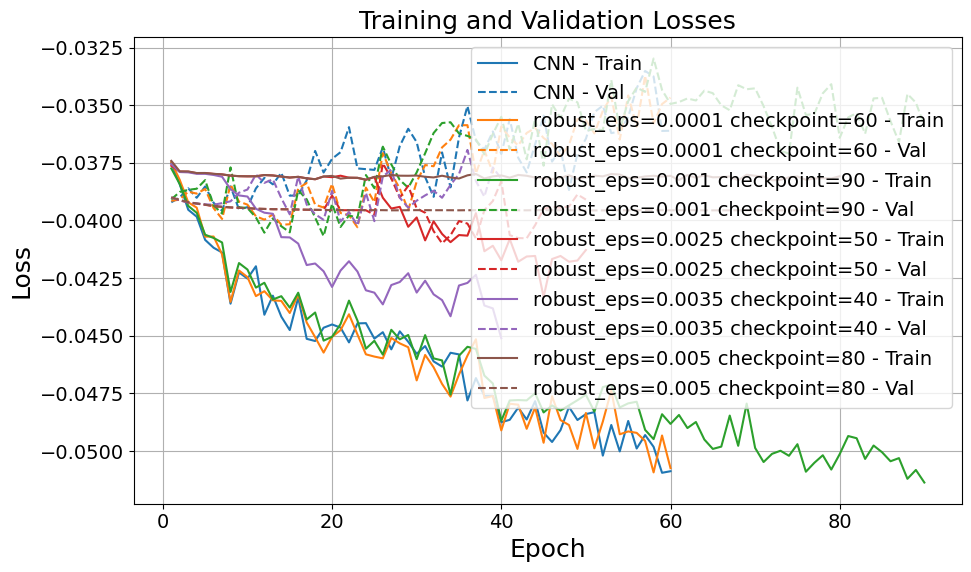

--------------------
Test RESULTS
--------------------


/tmp/ipykernel_1371633/1405371290.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,8.75,0.0914,0.482,1.12,0.00394,0.0431
robust_eps=0.0001 checkpoint=60,5.49,0.081,0.451,1.17,0.00329,0.0406
robust_eps=0.001 checkpoint=90,12.7,0.0994,0.301,1.14,0.00448,0.0451
robust_eps=0.0025 checkpoint=50,8.79,0.0914,0.503,1.23,0.00397,0.0435
robust_eps=0.0035 checkpoint=40,4.69,0.0817,0.393,1.24,0.00298,0.0365
robust_eps=0.005 checkpoint=80,1.39,0.0577,0.246,1.37,0.00154,0.0267


(752,)
(752,)
(752,)
(752,)
(752,)
(752,)


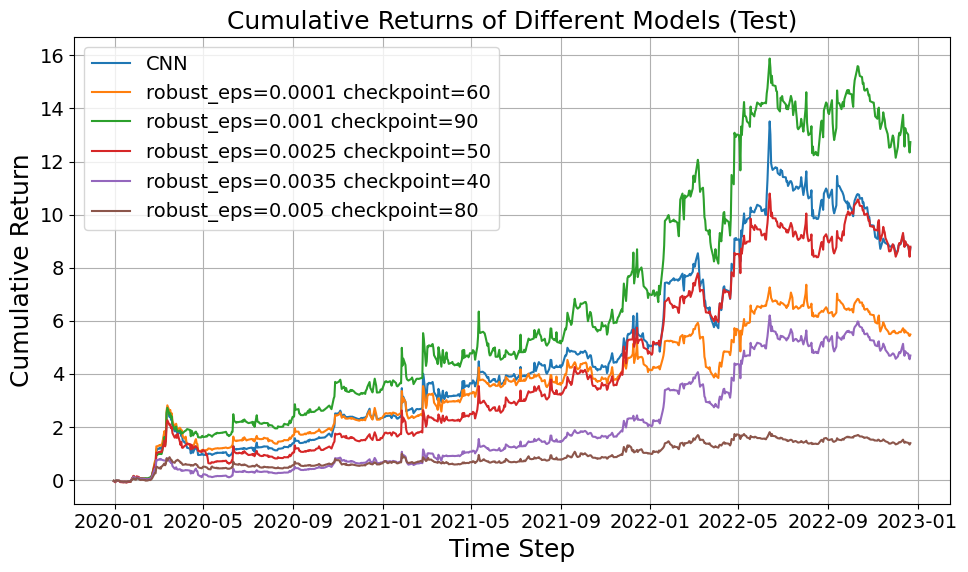

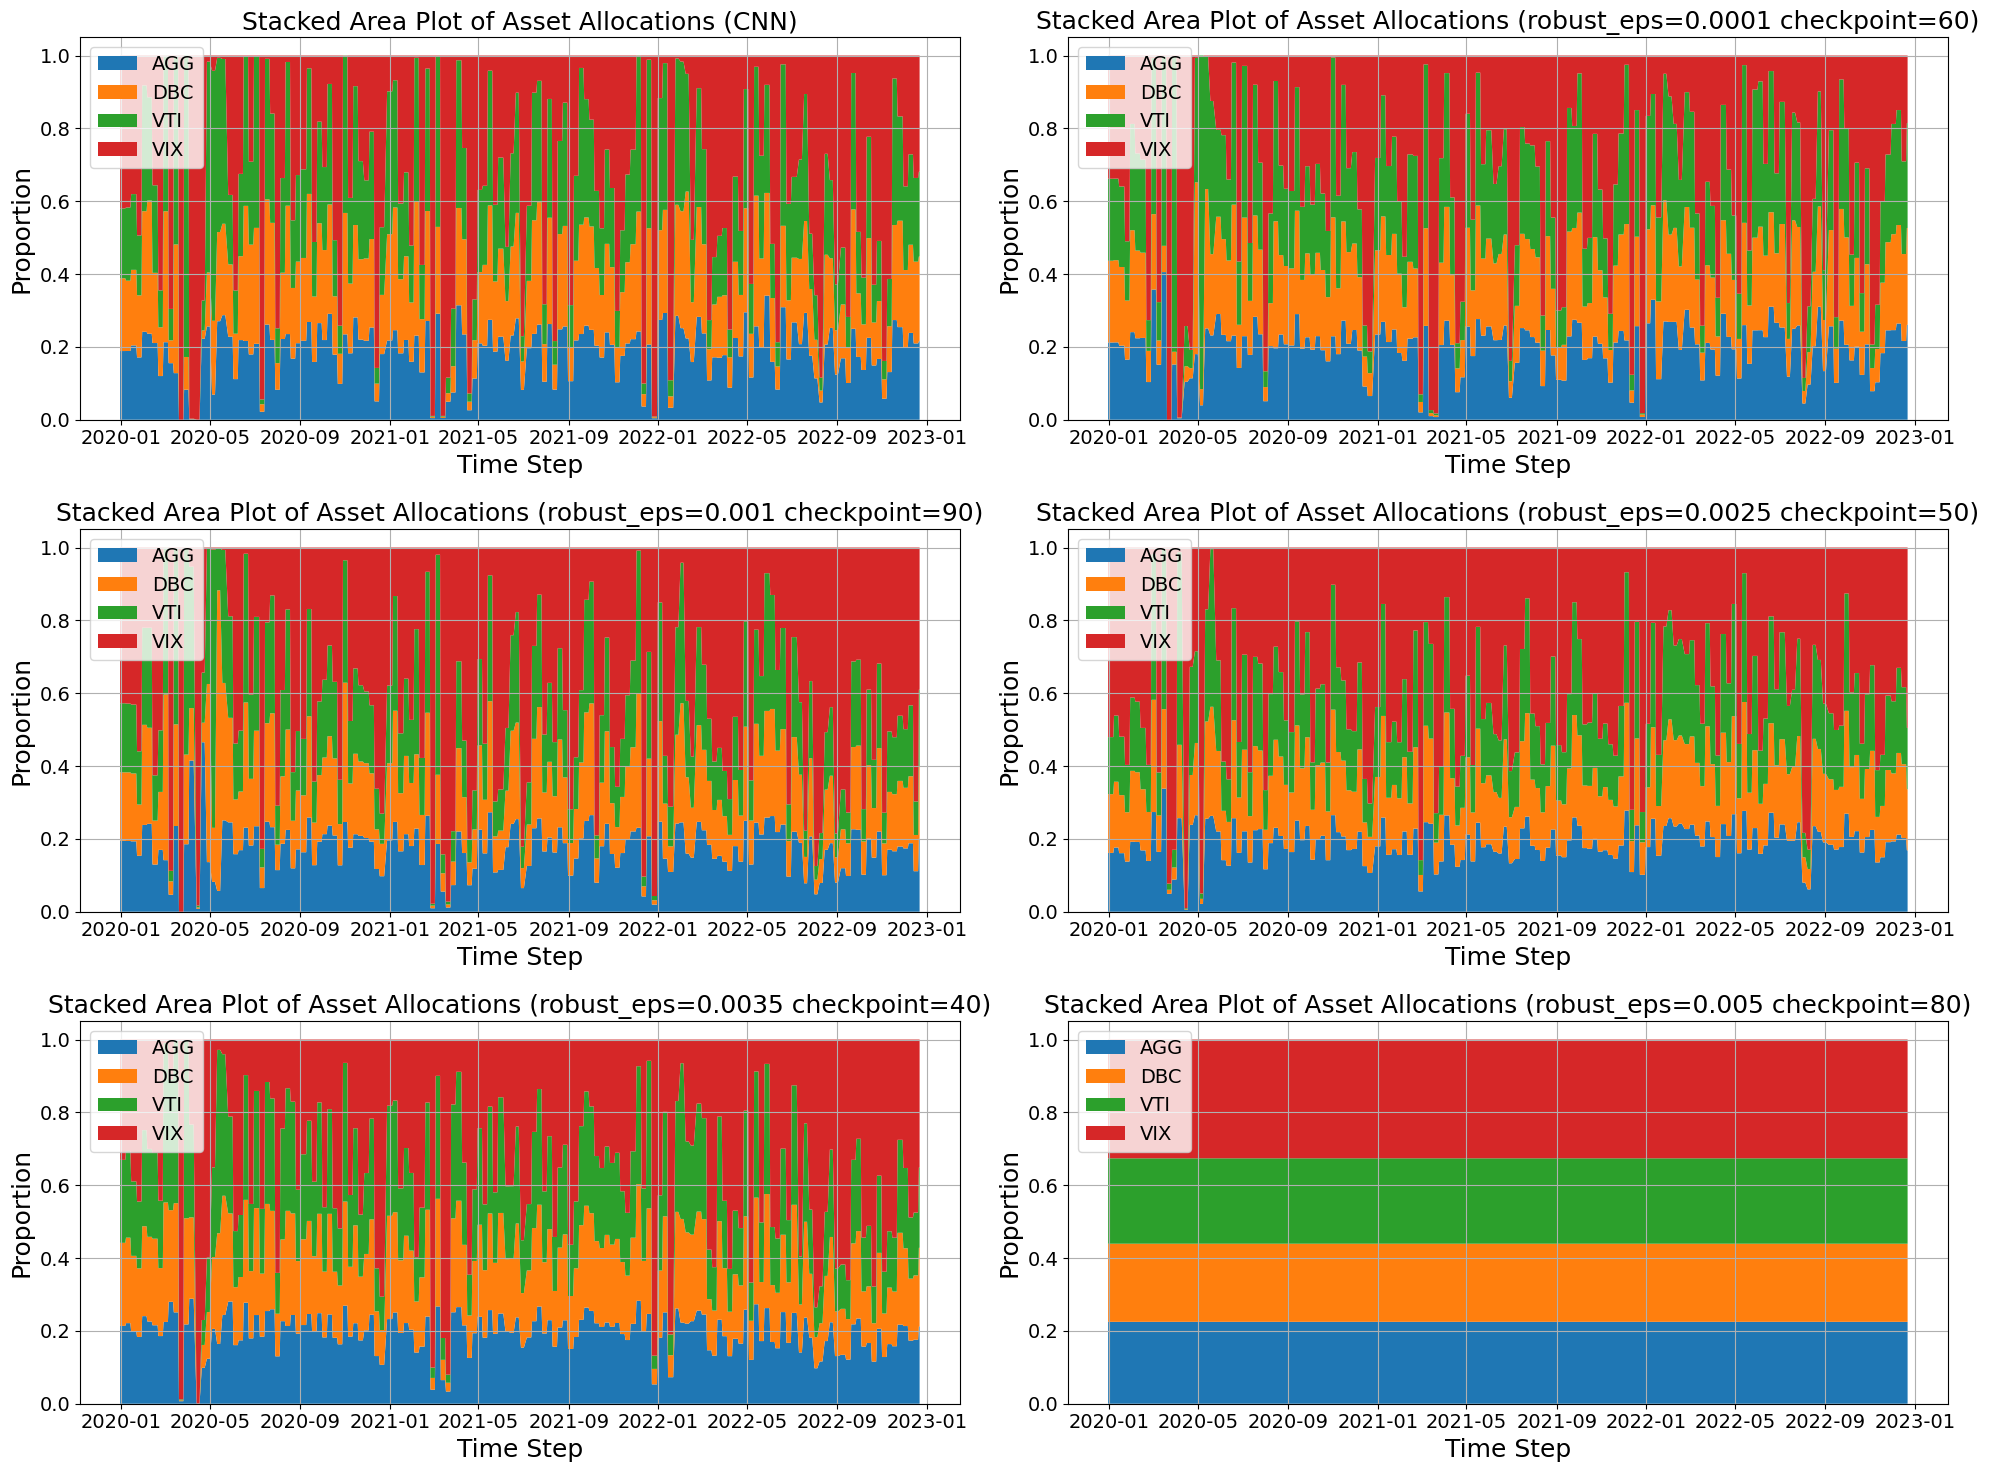

--------------------
Val RESULTS
--------------------


/tmp/ipykernel_1371633/1405371290.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(lambda x: f"{x:.3g}" if isinstance(x, float) else x)


,expected_return,sharpe_ratio,max_drawdown,mean_entropy,mean_return,std_return
CNN,1.44,0.0533,0.512,1.13,0.00233,0.0437
robust_eps=0.0001 checkpoint=60,2.71,0.0654,0.539,1.14,0.00315,0.0482
robust_eps=0.001 checkpoint=90,1.87,0.0583,0.519,1.11,0.00273,0.0467
robust_eps=0.0025 checkpoint=50,1.92,0.0584,0.384,1.21,0.00273,0.0467
robust_eps=0.0035 checkpoint=40,1.76,0.0601,0.401,1.26,0.00235,0.0391
robust_eps=0.005 checkpoint=80,0.739,0.0426,0.304,1.37,0.00138,0.0323


(626,)
(626,)
(626,)
(626,)
(626,)
(626,)


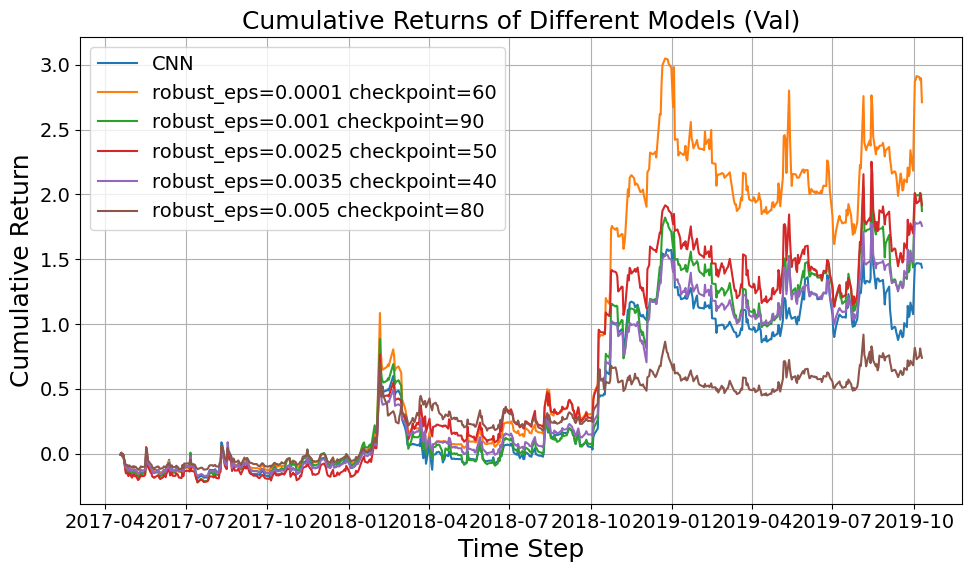

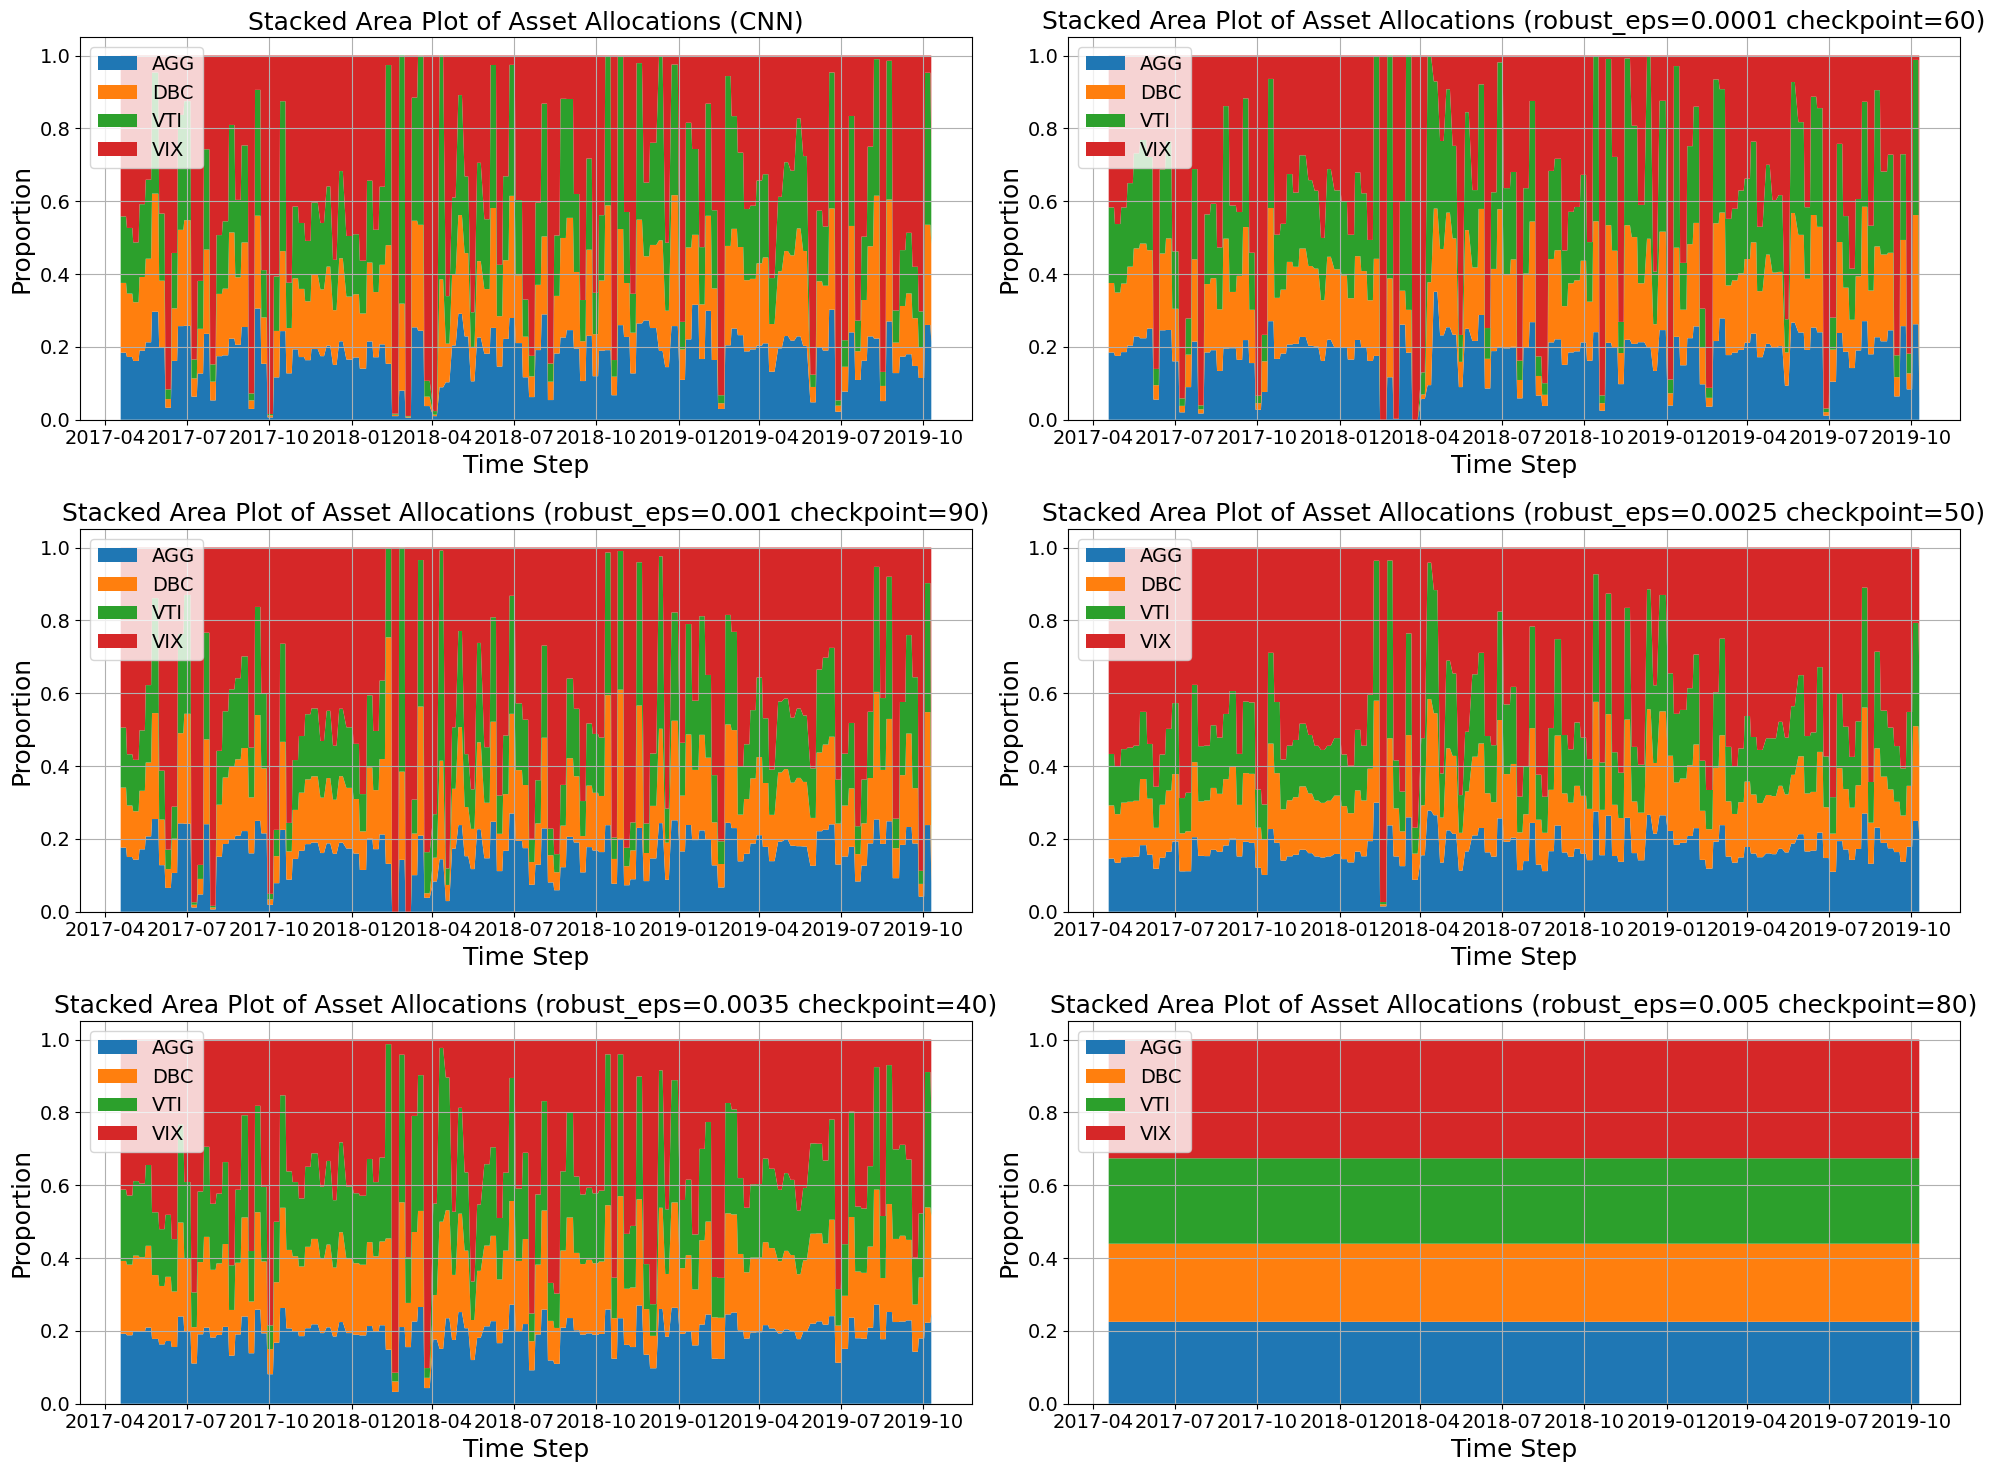

In [ ]:
# best_params = hyperparam_search(experiments, over="checkpoint")
# filtered_experiements = CNN_experiments | { ek: e for ek,e in experiments.items() if all([(best_params[pk] == e["params"][pk] or pk == "checkpoint") for pk in best_params])}
# filtered_experiements = experiments

# filtered_experiements["Best CNN"] = CNN_experiments
display_train_results(filtered_experiements)
for dataset_key, dataset_idx in zip(["test", "val"], [test_idx,val_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(filtered_experiements, dataset_key, dataset_idx )

PGD Results table


,epsilon,delta,CNN,robust_eps=0.0001 checkpoint=60,robust_eps=0.001 checkpoint=90,robust_eps=0.0025 checkpoint=50,robust_eps=0.0035 checkpoint=40,robust_eps=0.005 checkpoint=80
0,0.05,0.010,0.37,0.41,0.34,0.09,0.23,0.0
1,0.05,0.025,0.11,0.14,0.12,0.03,0.05,0.0
2,0.05,0.050,0.04,0.04,0.02,0.01,0.01,0.0
3,0.05,0.100,0.01,0.01,0.00,0.00,0.00,0.0
4,0.05,0.200,0.01,0.00,0.00,0.00,0.00,0.0
5,0.10,0.010,0.54,0.64,0.58,0.33,0.50,0.0
6,0.10,0.025,0.31,0.31,0.26,0.08,0.17,0.0
7,0.10,0.050,0.11,0.13,0.10,0.02,0.04,0.0
8,0.10,0.100,0.03,0.03,0.02,0.01,0.01,0.0
9,0.10,0.200,0.01,0.01,0.01,0.00,0.00,0.0


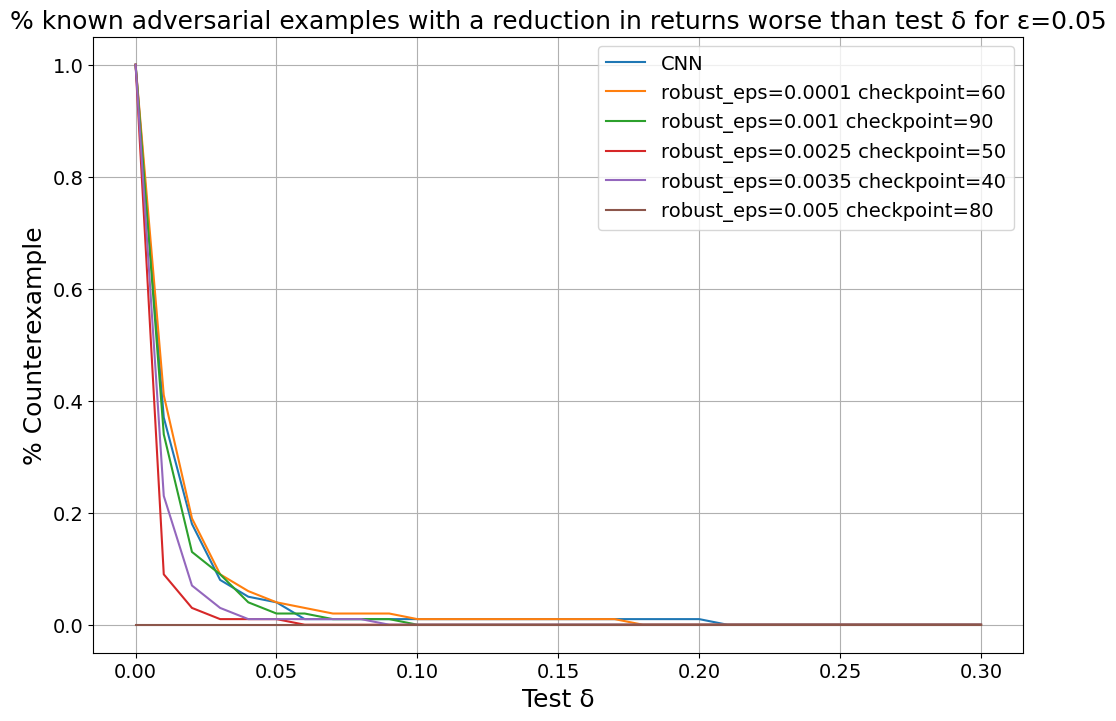

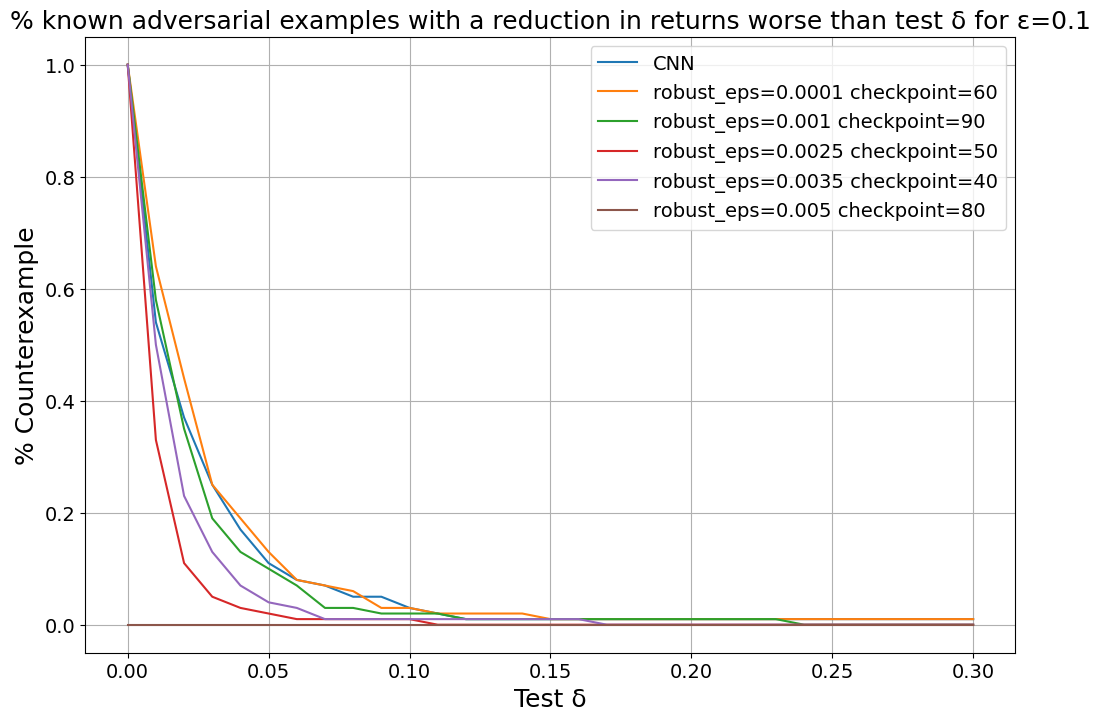

In [ ]:
exps = filtered_experiements
for model_name, model in exps.items():
    model["bounded_model"] = model["model"]
# exps = {"LSTM": }
test_eps = [0.05, 0.1]
test_delta = [0.01, 0.025, 0.05, 0.1, 0.2]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

def find_counterexamples(exps, test_delta):
    counterexamples = []
    for model_name, model in exps.items():
        for e in test_eps:
            for d in test_delta:
                true_deltas = model["results"]["test"]["deltas"]["PGD"][e]
                num_counterexamples = torch.abs(true_deltas) > d
                num_examples = num_counterexamples.shape[0]
                counterexamples.append({
                    "model": model_name,
                    "epsilon": e,
                    "delta": d,
                    "counterexamples": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                })

    counterexamples_df = pd.DataFrame(counterexamples)  

    counterexamples_df = counterexamples_df.pivot(index=["epsilon", 'delta'], columns='model', values='counterexamples')
    counterexamples_df = counterexamples_df.reset_index()
    counterexamples_df.columns.name = None
    counterexamples_df

    return counterexamples_df

PGD_results_table = find_counterexamples(exps, test_delta)
print("PGD Results table")
display(PGD_results_table)

test_delta_graph = np.array(list(range(31)))/100

PGD_results_graph = find_counterexamples(exps, test_delta_graph)

for eps, df_eps in PGD_results_graph.groupby("epsilon"):
    plt.figure(figsize=(12, 8))
    for model in exps.keys():
        plt.plot(df_eps["delta"], df_eps[model], label=model)
    plt.xlabel("Test δ")
    plt.ylabel("% Counterexample")
    plt.title(f"% known adversarial examples with a reduction in returns worse than test δ for ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
exps = experiments | CNN_experiments
for model_name, model in exps.items():
    model["bounded_model"] = model["model"]
counterexamples = []
test_eps = [0.1]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
## Maybe do one to show that training the model with robustness make the model more robust
## Models# Top 5 models at each train EPS over hyperparameter seach


/tmp/ipykernel_1371633/2210458396.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_labels))


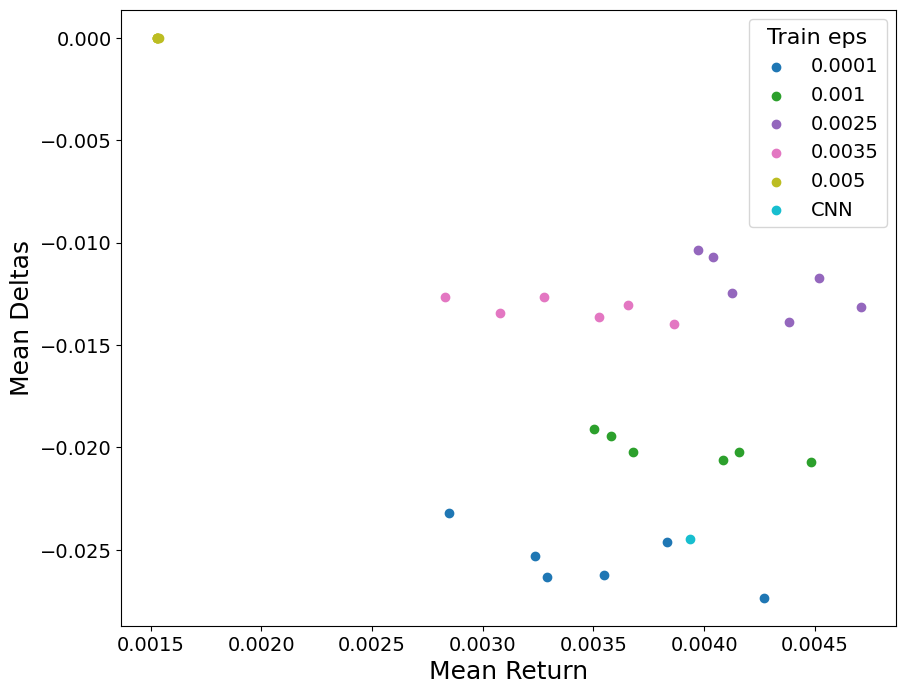

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

# 1. Collect all unique labels (robust_eps) across your experiments
all_labels = [str(model["params"].get("robust_eps", "CNN")) for model in exps.values()]
unique_labels = sorted(set(all_labels))


cmap = cm.get_cmap('tab10', len(unique_labels))
color_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(10,8))
seen = set()  # keep track of which labels we've already added to the legend

for model_name, model in exps.items():
    label = str(model["params"].get("robust_eps", "CNN"))
    color = color_dict[label]

    if model["params"]["checkpoint"] < 50:
        continue

    for e in test_eps:
        mean_deltas = torch.mean(model["results"]["test"]["deltas"]["PGD"][e])
        mean_return = model["results"]["test"]["metrics"]["mean_return"]
        
        if label not in seen:
            # first time we see this label → draw with label=... so it appears in legend
            plt.scatter(mean_return, mean_deltas, color=color, label=str(label))
            seen.add(label)
        else:
            # already saw this label → draw without label
            plt.scatter(mean_return, mean_deltas, color=color)

plt.legend(title="Train eps")
plt.xlabel("Mean Return")
plt.ylabel("Mean Deltas")
plt.show()


/tmp/ipykernel_1371633/2463857210.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_labels))


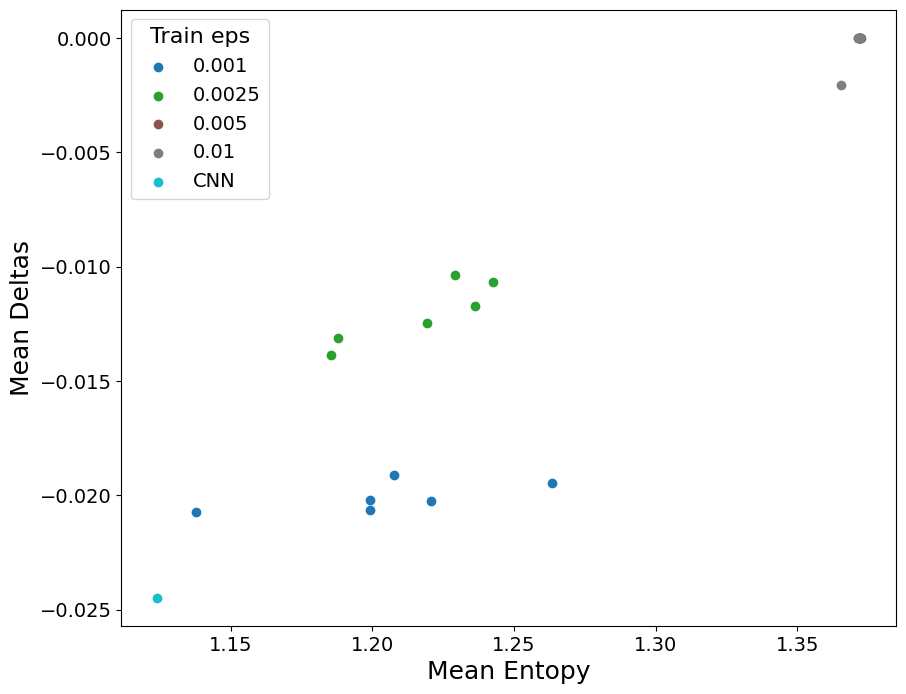

In [ ]:
# Top 5 models at each train EPS over hyperparameter seach

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

# 1. Collect all unique labels (robust_eps) across your experiments
all_labels = [str(model["params"].get("robust_eps", "CNN")) for model in exps.values()]
unique_labels = sorted(set(all_labels))

# 2. Build a color‐map that assigns one color per unique label
#    Here we use the "tab10" colormap (up to 10 distinct colors);
#    if you have more than 10 labels you can switch to a larger colormap.
cmap = cm.get_cmap('tab10', len(unique_labels))
color_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}

plt.figure(figsize=(10,8))
seen = set()  # keep track of which labels we've already added to the legend

for model_name, model in exps.items():
    label = str(model["params"].get("robust_eps", "CNN"))
    color = color_dict[label]

    if model["params"]["checkpoint"] < 50:
        continue

    for e in test_eps:
        mean_deltas = torch.mean(model["results"]["test"]["deltas"]["PGD"][e])
        mean_return = model["results"]["test"]["metrics"]["mean_entropy"]
        
        if label not in seen:
            # first time we see this label → draw with label=... so it appears in legend
            plt.scatter(mean_return, mean_deltas, color=color, label=str(label))
            seen.add(label)
        else:
            # already saw this label → draw without label
            plt.scatter(mean_return, mean_deltas, color=color)

plt.legend(title="Train eps")
plt.xlabel("Mean Entopy")
plt.ylabel("Mean Deltas")
plt.show()


/tmp/ipykernel_1371633/2432921631.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_labels))


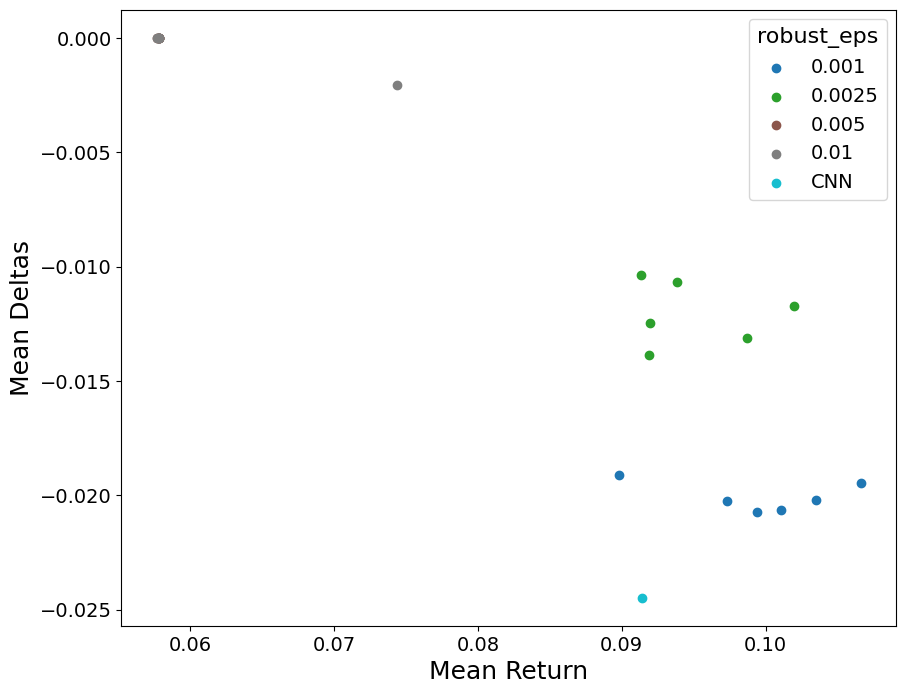

## Adversarial Attacks

In [ ]:
mlp = experiments["MLP"]
cnn = experiments["CNN"]
LSTM_Unrolled = experiments["LSTM_Unrolled"]
transformer = experiments["Transformer"]
lstm = experiments["LSTM"]

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}

KeyError: 'MLP'

In [ ]:
for model_name, model in exps.items():
    model["bounded_model"] = get_bounded_model(model)

In [ ]:
test_eps = [0.1]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(experiments, x, y, test_eps)
# bound_experiments(exps, [], x, [])
# get_experiment_returns(exps, y)
# deltas_experiments(exps)
pgd_attack_experiments(experiments, X_test_tensor[::horizon], y_test_tensor[::horizon], test_eps)


In [ ]:
model_names = ["CNN"]
for model_name in model_names:
    first = exps[model_names[0]]["results"]["test"]["deltas"]["PGD"]
    thresholds = sorted(first.keys())
    for eps in test_eps:
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]
        returns = exps[model_name]["results"]["test"]["returns"]


        model_returns = returns["None"]
        pgd_returns = returns["PGD"][eps]

        model = exps[model_name]["model"]

        mask_pos_in_a = model_returns > 0       # True where 'a' is positive
        mask_neg_in_b = pgd_returns < 0       # True where 'b' is negative

        # 2) Combine them: only indices where BOTH are True
        combined_mask = mask_pos_in_a & mask_neg_in_b

        # 3) Extract the integer indices where combined_mask is True
        #    torch.nonzero(...) returns a tensor of shape (N, 1) for a 1D mask, so we .flatten() or .squeeze().
        intersection_idx = torch.nonzero(combined_mask)
        # print(intersection_idx)
        # print(model_returns[:5])
        # print(pgd_returns)
        # print(pgd_returns[:5])
        # print(deltas[intersection_idx])
        # 0/0
        


      
        # print(intersection_idx)
        # print(deltas[intersection_idx])

        test = deltas[intersection_idx]
        

        # print(torch.argmin(test))


        min_idx = torch.argmin(pgd_returns[intersection_idx])
        min_idx = intersection_idx[min_idx].cpu().detach().numpy()[0]
        # print(min_idx)
        # print(deltas[min_idx])
        print("Clean return", returns["None"][min_idx].cpu().detach().numpy())
        print("Adversarial return", returns["PGD"][eps][min_idx].cpu().detach().numpy())

    
        adv_X = exps[model_name]["results"]["test"]["PGD_AdvX"][eps]

        

        
        adv_Y = exps[model_name]["results"]["test"]["PGD_AdvY"][eps]
        deltas = exps[model_name]["results"]["test"]["deltas"]["PGD"][eps]

        model_weights = exps[model_name]["results"]["test"]["bounds"]["None"]

        data_np = X_test_tensor[::5][min_idx].numpy()
        data_np2 = adv_X[min_idx].cpu().numpy()

        time = range(data_np.shape[0])  # 0,1,…,49

        # Create a 2×2 grid of subplots
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        for i, ax in enumerate(axes):

            print(data_np[:, i].shape)
            ax.plot(time, torch.tensor(data_np[:, i]) * saved_std[i] + saved_mean[i],  linestyle='-')
            ax.plot(time, torch.tensor(data_np2[:, i]) * saved_std[i] + saved_mean[i], linestyle='--')
            ax.set_title(f'{asset_names[i]}')
            ax.set_ylabel('Value')
            ax.grid(True, linestyle='--', alpha=0.5)

        # Label the shared x-axis on the bottom row
        for ax in axes[2:]:
            ax.set_xlabel('Time')

        # fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(eps[model_name]["params"], exps)} {eps}', y=0.95)
        plt.tight_layout()
        plt.show()


        weights_clean = model(X_test_tensor[::5][min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)
        weights_adv   = model(adv_X[min_idx].to(device).unsqueeze(0)).cpu().detach().numpy().squeeze(0)

        # X-axis positions for the two scenarios
        x = np.arange(2)

        # Compute cumulative bottoms for stacking
        bottom_idx0 = np.zeros(2)
        bottom_idx1 = np.zeros(2)
        bottom_idx2 = np.zeros(2)

        # Plot stacked bar chart
        plt.figure(figsize=(6, 5))

        # Index 0
        plt.bar(x,
                [weights_clean[0], weights_adv[0]],
                label=asset_names[0])

        # Index 1 on top of Index 0
        bottom_idx0 = [weights_clean[0], weights_adv[0]]
        plt.bar(x,
                [weights_clean[1], weights_adv[1]],
                bottom=bottom_idx0,
                label=asset_names[1])

        # Index 2 on top of Index 0 + Index 1
        bottom_idx1 = [weights_clean[0] + weights_clean[1],
                    weights_adv[0]   + weights_adv[1]]
        plt.bar(x,
                [weights_clean[2], weights_adv[2]],
                bottom=bottom_idx1,
                label=asset_names[2])

        # Index 3 on top of Index 0 + Index 1 + Index 2
        bottom_idx2 = [weights_clean[0] + weights_clean[1] + weights_clean[2],
                    weights_adv[0]   + weights_adv[1]   + weights_adv[2]]
        plt.bar(x,
                [weights_clean[3], weights_adv[3]],
                bottom=bottom_idx2,
                label=asset_names[3])

        # Labels, ticks, title, and legend
        plt.xticks(x, ['Clean Output', 'Adversarial Output'])
        plt.xlabel('Output Type')
        plt.ylabel('Weight Value')
        plt.title('Stacked Bar Plot: Clean vs. Adversarial Weights')
        plt.legend(title='Weight Index')
        plt.tight_layout()
        plt.show()

        

In [ ]:
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
# exps = {"LSTM": }
test_eps = [0.05, 0.01, 0.25, 0.1]
test_delta = [0.01, 0.025, 0.05, 0.1]
x = X_test_tensor[::horizon]
y = y_test_tensor[::horizon]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, [], x, [])
get_experiment_returns(exps, y)
deltas_experiments(exps)

def find_counterexamples(exps, test_delta):
    counterexamples = []
    for model_name, model in exps.items():
        for e in test_eps:
            for d in test_delta:
                true_deltas = model["results"]["test"]["deltas"]["PGD"][e]
                num_counterexamples = torch.abs(true_deltas) > d
                num_examples = num_counterexamples.shape[0]
                counterexamples.append({
                    "model": model_name,
                    "epsilon": e,
                    "delta": d,
                    "counterexamples": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                })

    counterexamples_df = pd.DataFrame(counterexamples)  

    counterexamples_df = counterexamples_df.pivot(index=["epsilon", 'delta'], columns='model', values='counterexamples')
    counterexamples_df = counterexamples_df.reset_index()
    counterexamples_df.columns.name = None
    counterexamples_df

    return counterexamples_df

PGD_results_table = find_counterexamples(exps, test_delta)
print("PGD Results table")
display(PGD_results_table)

test_delta_graph = np.array(list(range(31)))/100

PGD_results_graph = find_counterexamples(exps, test_delta_graph)

for eps, df_eps in PGD_results_graph.groupby("epsilon"):
    plt.figure(figsize=(12, 8))
    for model in exps.keys():
        plt.plot(df_eps["delta"], df_eps[model], label=model)
    plt.xlabel("Test δ")
    plt.ylabel("% Counterexample")
    plt.title(f"% known adversarial examples with a reduction in returns worse than test δ for ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

NameError: name 'mlp' is not defined

## Verified bounds

In [ ]:
def get_robust(deltas, exps):
    robust = []
  


    for model_name, model in exps.items():

        # print(model_name)
        # print(model["results"]["test"]["deltas"])

        for method_name, method in model["results"]["test"]["deltas"].items():
            # print(method_name)
            if method_name in ["PGD", "None"]:
                continue

            # print(method)
            
            for eps, true_deltas in method.items():
                # for e in test_eps:
                    # true_deltas = model["results"]["test"]["deltas"][method][e]
                for d in deltas:
                    num_counterexamples = torch.abs(true_deltas) <= d
                    num_examples = num_counterexamples.shape[0]
                    robust.append({
                        "model": model_name,
                        "method": method_name,
                        "epsilon": eps,
                        "delta": d,
                        "robust": round((float((sum(num_counterexamples)/ num_examples).cpu().detach().numpy())),2)
                    })
    return robust

# pd.DataFrame(get_robust(table_test_delta, exps))  


### IBP

In [ ]:
x = X_test_tensor[::horizon][:30]
y = y_test_tensor[::horizon][:30]

In [ ]:
test_eps = [0.001, 0.005, 0.01]
exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["IBP"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]

df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "IBP"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "IBP"
df = df[df["method"] == method]
for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps = {"MLP": mlp, "CNN": cnn} #"LSTM TODO"#, "Transformer": transformer, "LSTM": LSTM_Unrolled}
methods = ["CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, {"MLP": mlp, "CNN": cnn}))  
df = df[df["method"] == "CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(31)))/100
df = pd.DataFrame(get_robust(graph_test_delta, exps))

method = "CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure()
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under {method} of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

### ab-CROWN

In [ ]:
test_eps = [0.01, 0.025, 0.05, 0.1]
exps =  {"MLP": mlp, "CNN": cnn}
methods = ["ab-CROWN"]
pgd_attack_experiments(exps, x, y, test_eps)
# bound_experiments(exps, methods, x, test_eps)
get_experiment_returns(exps, y)
deltas_experiments(exps)

In [ ]:
table_test_delta = [0.01, 0.025, 0.05, 0.1]
df = pd.DataFrame(get_robust(table_test_delta, exps))  
df = df[df["method"] == "ab-CROWN"]
df = df.pivot(index=["epsilon", 'delta'], columns='model', values='robust')
df = df.reset_index()
df.columns.name = None
df

In [ ]:
graph_test_delta = np.array(list(range(61)))/240
df = pd.DataFrame(get_robust(graph_test_delta, exps))
method = "ab-CROWN"
df = df[df["method"] == method]

for eps, df_eps in df.groupby("epsilon"):
    # for method, df_eps_method in df_eps.groupby("method"):
    plt.figure(figsize=(10,6))
    for model_name, df_model in df_eps.groupby("model"):
        plt.plot(df_model["delta"], df_model["robust"], label=model_name)
    plt.xlabel("Test δ")
    plt.ylabel("% Certified Robust")
    plt.title(f"Certified Robustness under α,β-CROWN of models tested at ε={eps}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# df_tables = pd.DataFrame(get_robust(table_test_delta))  
# for method_name, df_table in df_tables.groupby("method"):
#     display(df_table)

In [ ]:
# graph_test_delta = np.array(list(range(31)))/100
# df_graphs = pd.DataFrame(get_robust(graph_test_delta))

# for eps, df_eps in df_graphs.groupby("epsilon"):
#     for method, df_eps_method in df_eps.groupby("method"):
#         plt.figure()
#         for model_name, df_model in df_eps_method.groupby("model"):
#             plt.plot(df_model["delta"], df_model["robust"], label=model_name)
#         plt.xlabel("test_delta")
#         plt.ylabel("% Certified Robust")
#         plt.title(f"{method} {eps}")
#         plt.grid(True)
#         plt.legend()
#         plt.show()

## Runtime Analysis

In [ ]:
import time as time

In [ ]:
N = 1

exps = {"MLP": mlp, "CNN": cnn, "Transformer": transformer, "LSTM": LSTM_Unrolled}


bound_performance_path = os.path.join(experiment_path, "bound_performance8.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

methods = ["IBP", "PGD", "CROWN-IBP", "CROWN", "ab-CROWN"]
skip = {
    "MLP": [],
    "CNN": [],
    "Transformer": methods,#["CROWN", "CROWN-IBP", "ab-CROWN"],
    "LSTM": methods#["ab-CROWN", "CROWN"],

}


for N in [1]:
    x = X_test_tensor[:N]
    y = y_test_tensor[:N]
    N = str(N)
    if N not in bound_performance :
        bound_performance[N] = {}
    for method in methods:
        if method not in bound_performance[N] :
            bound_performance[N][method] = {}
        for model_name, model_dict in exps.items():
            if model_name in bound_performance[N][method]:
                print(f"Already tested {model_name} {method} {N}")
                continue 

            if method in skip[model_name]:
                print(f"Skipping {model_name} {method} {N}")
                continue 

            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]
            
            bounds = None
            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, x.to(device), y.to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bounds = bound_model(bounded_model, x.to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {N} - {time_taken}")
            mean_width = None
            if bounds is not None:     
                mean_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            bound_performance[N][method][model_name] = {"time_taken": time_taken, "mean_width": mean_width}


            print(bound_performance)
            # print(bound_performance[N][method][model_name])
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'N': int(run),
                'method': method,
                'model': model,
                'value': value*100 / int(run)
            })

df = pd.DataFrame(rows)
df = df[df["N"] == 8]
# Aggregate value over runs (compute mean)
# agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
df =  df.pivot(index=['model',"N"], columns='method', values='value').reset_index()

df

In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
bounds_dict = []
for model_name, model in exps.items():
    for method in model["results"]["test"]["deltas"].keys():
        if method in ["PGD", "None"]:
            continue
        for e in model["results"]["test"]["deltas"][method].keys():
            true_deltas = model["results"]["test"]["deltas"][method][e]
            bounds = model["results"]["test"]["bounds"][method][e]

            mean_bound_width = torch.mean(torch.abs(bounds[1] - bounds[0]))
            mean_delta = torch.mean(true_deltas)

            bounds_dict.append({
                    "model": model_name,
                    "method": method,
                    "epsilon": e,
                    "mean_bound_width": round(float(mean_bound_width.cpu()),2),
                    "mean_delta": round(float(mean_delta.cpu()),2),
                })
print("Mean bound width. Mean delta")
df = pd.DataFrame(bounds_dict)  
display(df)

In [ ]:
exp = {"ml"}

In [ ]:
import time

In [ ]:
exp = experiments["seed=0,epochs=30,lambda_entropy=0.001,model=MLP,learning_rate=0.001,checkpoint_freq=3,rebalance_freq=5,checkpoint=3.pth"]
exp2 = experiments["seed=0,epochs=30,lambda_entropy=0.0025,model=CNN,learning_rate=0.001,checkpoint_freq=10,rebalance_freq=5,checkpoint=10.pth"]
exp3 = experiments["seed=0,epochs=100,lambda_entropy=0.025,model=LSTM_Unrolled,lstm_layers=4,lstm_hidden_layers=1,learning_rate=0.001,rebalance_freq=5,checkpoint_freq=8,checkpoint=64.pth"]
# device = "cpu"
bound_performance_path = os.path.join(experiment_path, "bound_performance.csv")
os.makedirs(os.path.dirname(bound_performance_path), exist_ok=True)
if os.path.exists(bound_performance_path):
    with open(bound_performance_path, 'r') as file:
        bound_performance = json.load(file)
else:
    bound_performance = {}

eps = {"mlp": exp, "cnn": exp2, "lstm": exp3}

for run in range(3):
    run = str(run)
    if run not in bound_performance:
        bound_performance[run] = {}
    for method in ["IBP", "PGD", "CROWN-IBP", "CROWN"]:
        if method not in bound_performance[run] :
            bound_performance[run][method] = {}
        for model_name, model_dict in eps.items():
            if model_name in bound_performance[run][method]:
                print(f"Already tested {model_name} {method} {run}")
                continue 
            
            if ("model_bounded" not in model_dict):
                print(f"Loading bounded model for {model_name}")
                model_dict["model_bounded"] = get_bounded_model(model_dict)
            bounded_model = model_dict["model_bounded"]

            start_time = time.time()
            if method == "PGD":
                pgd_attack(bounded_model, X_test_tensor[::horizon].to(device), y_test_tensor[::horizon].to(device), 0.1, pgd_attack_loss, step_size=20, device=device)
            else:
                bound_model(bounded_model, X_test_tensor[::horizon].to(device), 0.1, method)
            time_taken = time.time() - start_time
            print(f"{model_name} {method} {run} - {time_taken}")

            bound_performance[run][method][model_name] = time_taken
            with open(bound_performance_path, 'w') as file: 
                json.dump(bound_performance, file, indent=4)


In [ ]:
import pandas as pd


# Convert to DataFrame
rows = []
for run, methods in bound_performance.items():
    for method, models in methods.items():
        for model, value in models.items():
            rows.append({
                'run#': int(run),
                'method': method,
                'model': model,
                'value': value
            })

df = pd.DataFrame(rows)

# Aggregate value over runs (compute mean)
agg_df = df.groupby(['method', 'model'], as_index=False)['value'].mean()

# Pivot so that 'model' remains rows and 'method' become columns
pivot_df = agg_df.pivot(index='model', columns='method', values='value').reset_index()

pivot_df

In [ ]:
# def loss_fn_fn(params):
#     lambda_entropy = params["lambda_entropy"]
#     def loss_fn(x, y, model):
#         weights = model(x)

#         asset_returns = ((1 + y).prod(1)-1)
#         portfolio_returns = (asset_returns*weights).sum(1)
#         natural_loss = -portfolio_returns.mean() 
#         clamped_weights = weights.clamp(min=1e-8)
#         entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())
#         return natural_loss -  entropy_loss
#     return loss_fn 
    
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
#     else:
#         model = SimpleAssetAllocationModel(4*lookback)

#     return model

# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20, 30],
#     "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1],
#     "model": ["CNN"],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
# },
# ]

# experiment_path = "fyp3/experiments/standard_model/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["val"] = run_experiment(model, (X_val_tensor, y_val_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "val", "train",], [test_idx, val_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:

def loss_fn_fn(params):
    lambda_risk = 1.5
    lambda_entropy = params["lambda_entropy"]


    def loss_fn(x, y, model):
        weights_ = model(x)
        
        weights = weights_.unsqueeze(1).repeat(1, horizon, 1)

        portfolio_returns = (weights * y).sum(1).sum(1)

        natural_loss = -portfolio_returns.mean() 

        clamped_weights = weights.clamp(min=1e-8)
        entropy_loss = lambda_entropy * (-(clamped_weights * clamped_weights.log()).sum(dim=1).mean())

        return natural_loss -  entropy_loss
    return loss_fn
    

def model_fn(params):
    if params["model"] == "CNN":
        model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"]).to(device)
    else:
        model = SimpleAssetAllocationModel(4*lookback)

    return model

params_grids = [{
    "seed": [441],
    "epochs": [10],
    "lambda_entropy": [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.5, 1.0],
    # "lambda_entropy": [0.0],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp3/experiments/standard_model/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
params_grids = [{
    "seed": [441,2,3],
    "epochs": [10, 20, 30],
    "lambda_entropy": [1e-2],
    "model": ["CNN"],
    "dropout": [0.1, 0],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
},
]

experiment_path = "fyp2/experiments/standard_model/"

experiments = get_experiment_model(model_fn, experiment_path, params_grids, loss_fn_fn)
experiments["Uniform Baseline"] = {"model": UniformModel(), "params": {"label": "Uniform Baseline"}, "results": {}}


for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx )

# Robust Analysis (old)

In [ ]:
# def model_fn(params):
#     if params["model"] == "CNN":
#         model = CNNAllocatorCausal(4, lookback, dropout_rate=params["dropout"])
#         bound_opts = {
#             "optimize_bound_args": {
#                 "enable_alpha_crown": True,   # α-CROWN
#                 "enable_beta_crown": True,    # β-CROWN (branch-and-bound)
#                 "optimizer": "adam",          
#                 "iteration": 5,              # α/β optimization steps
#                 "lr_alpha": 0.5,
#                 "lr_beta": 0.05,
#                 "pruning_in_iteration": True
#             },
#             "verbose":True,
#             "conv_mode": "matrix"
#         }
#         model = BoundedModule(model.to(device), X_train_tensor.to(device), bound_opts=bound_opts).to(device)

#     else:
#         model = SimpleAssetAllocationModel(4*lookback) 
#         model = BoundedModule(model, X_train_tensor).to(device)
        
#     return model


# params_grids = [{
#     "seed": [0],
#     "epochs": [10, 20],
#     "model": ["CNN"],
#     "alpha": [0.5],
#     "robust_eps": [0.0005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["CROWN-IBP"],
#     "lambda_entropy": [0.025]
# },
# {
#     "seed": [0],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0],
#     "robust_eps": [0.0000],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "loss": ["Standard"],
#     "lambda_entropy": [0.025]
# },
# ]

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx )

In [ ]:
# def bound_model(model, x, eps, method, batch_size=1):
#     upper_batches = []
#     lower_batches = []
#     x = x.to(device)
#     N = x.shape[0]

#     if method == "CROWN-Optimized":
#         model.get_split_nodes()

#     out_shape = (N, 4)

#     for i in tqdm(range(0, N, batch_size)):
#         x_batch = x[i: i+batch_size]
#         eps_vector = torch.tensor(eps, dtype=torch.float32, device=device)  # One ε per asset
#         eps_tensor = eps_vector.view(1, 1, -1).expand_as(x_batch) 

#         perturbation = PerturbationLpNorm(norm=np.inf, eps=eps_tensor)
#         x_perturbed = BoundedTensor(x_batch, perturbation)
#         lb, ub = model.compute_bounds(x=(x_perturbed,), method=method)
#         lower_batches.append(lb.to(device))
#         upper_batches.append(ub.to(device))

#     lb_out = torch.zeros(out_shape, device=device)
#     ub_out = torch.ones(out_shape, device=device)

#     lower_all = torch.cat(lower_batches, dim=0)
#     upper_all = torch.cat(upper_batches, dim=0)

#     lower_all = torch.max(lower_all, lb_out)
#     upper_all = torch.min(upper_all, ub_out)

#     return lower_all, upper_all

In [ ]:

# def loss_fn(x, y):
#     loss = ((1 + y).prod(1) * x).sum(1)
#     return loss

In [ ]:
# test_period = 20
# test_eps = [1/100, 1/200]


In [ ]:
# eps_tensor = torch.tensor(e, dtype=torch.float32, device=device)

In [ ]:
# def bound_experiments(experiments, methods, x, test_eps):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]
        
#         experiment["results"]["test"]["bounds"] = {}
#         experiment["results"]["test"]["bounds"]["None"] = model(x)
        
#         for method in methods:
#             experiment["results"]["test"]["bounds"][method] = {}
#             for eps in test_eps:
#                 print(f"{method} {eps}")
#                 experiment["results"]["test"]["bounds"][method][eps] = bound_model(model, x, eps_tensor * eps, method, batch_size=1)

In [ ]:
# def pgd_attack_experiments(experiments, x, y, test_eps):
#     for model_name, experiment in experiments.items():
#         if "epochs" not in experiment["params"]:
#             continue
#         model = experiment["model"]

#         experiment["results"]["test"]["PGD"] = {}
#         experiment["results"]["test"]["PGD_AdvX"]  = {}
#         experiment["results"]["test"]["PGD_AdvY"]  = {}
#         for eps in test_eps:
#             attack_point = pgd_attack(model, x, y, (eps * eps_tensor), loss_fn)
#             experiment["results"]["test"]["PGD_AdvX"][eps] = attack_point
#             experiment["results"]["test"]["PGD_AdvY"][eps] = model(attack_point)

In [ ]:
# test_period = 10
# test_eps = [1/200, 1/500, 1/1000]
# x = X_test_tensor[::horizon].to(device)
# y = y_test_tensor[::horizon].to(device)
# pgd_attack_experiments(experiments, x, y, test_eps)

In [ ]:
# bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)

In [ ]:
# def get_experiment_returns(experiments, y):
#     for model_name, experiment in experiments.items():
#         model = experiment["model"]

#         model_weights = experiment["results"]["test"]["bounds"]["None"].to(device)
#         returns = experiment["results"]["test"]["returns"] = {}
#         asset_returns = (y+1).prod(1)-1

#         returns["None"] = (asset_returns * model_weights).sum(1)

#         for method in ["IBP", "CROWN"]:
#             returns[method] = {}
#             for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#                 ub, lb = bounds
#                 returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#         if "epochs" not in experiment["params"]:
#             continue

#         returns["PGD"] = {}

#         for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#             returns["PGD"][eps] = (asset_returns * weights).sum(1)
#             # print(returns["PGD"][eps])

In [ ]:
# get_experiment_returns(experiments, y)

In [ ]:
# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     y = y_test_tensor[::5][:test_period]

#     model_weights = experiment["results"]["test"]["bounds"]["None"]
#     returns = experiment["results"]["test"]["returns"] = {}
#     asset_returns = (y+1).prod(1)-1

#     returns["None"] = (asset_returns * model_weights).sum(1)

#     for method in ["IBP", "CROWN"]:
#         returns[method] = {}
#         for eps, bounds in experiment["results"]["test"]["bounds"][method].items():
#             ub, lb = bounds
#             returns[method][eps] = torch.min(asset_returns * lb, asset_returns * ub).sum(1)

#     if "epochs" not in experiment["params"]:
#         continue

#     returns["PGD"] = {}

#     for eps, weights in experiment["results"]["test"]["PGD_AdvY"].items():
#         returns["PGD"][eps] = (asset_returns * weights).sum(1)
#         print(returns["PGD"][eps])
        

In [ ]:
# def deltas_experiments(experiments):
#     for model_name, experiment in experiments.items():
#         returns = experiment["results"]["test"]["returns"] 
#         deltas = experiment["results"]["test"]["deltas"] = {}
#         model_returns = returns["None"]

#         for method, return_dict in returns.items():
#             if method == "None":
#                 continue
#             deltas[method] = {}
#             for eps, ret in return_dict.items():
#                 deltas[method][eps] = ((ret + 1) -(model_returns+1))/ (model_returns+1)  

# deltas_experiments(experiments)

In [ ]:
# model_names = list(experiments.keys())
# model_names.remove("Uniform Baseline")
# model_names

In [ ]:
# experiments.keys()

# experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

In [ ]:

# def box_plot_experiment(experiments, method):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"][method]
#     thresholds = sorted(first.keys())
#     n_thresh = len(thresholds)
#     model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#     # prepare figure
#     fig, ax = plt.subplots(figsize=(12,6))
    
#     # width of each box, total span = width * n_models
#     n_models = len(model_names)
#     width = 0.8 / n_models
#     ind = np.arange(n_thresh)
    
#     # define a color cycle or list here if you like
#     colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
#     # plot each model
#     box_handles = []
#     for i, model_name in enumerate(model_names):
#         data = experiments[model_name]["results"]["test"]["deltas"][method]

#         vals = [data[t].detach().cpu() for t in thresholds]
        
#         pos = ind - 0.4 + width*(i + 0.5)
#         b = ax.boxplot(
#             vals,
#             positions=pos,
#             widths=width,
#             patch_artist=True,
#             boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6),
#             medianprops=dict(color='black'),
#             manage_ticks=False
#         )
#         # grab one of the boxes for the legend
#         box_handles.append(b["boxes"][0])
    
#     # labels & legend
#     ax.set_xticks(ind)
#     ax.set_xticklabels([str(t) for t in thresholds])
#     ax.set_xlabel('Threshold')
#     ax.set_ylabel('Max change in returns')
#     ax.set_title(f'Model Comparison at Different Thresholds ({method})')
#     ax.legend(box_handles, model_labels, loc='upper left')
    
#     plt.tight_layout()
#     plt.show()

# for method in ["IBP", "CROWN", "PGD"]:
#     box_plot_experiment(experiments_to_display, method)

In [ ]:
# def plot_experiment_delta_returns_vs_epsilon(experiments):
#     model_names = list(experiments.keys())
#     fig, ax = plt.subplots(figsize=(12, 6))
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())
#     model_labels = ["CROWN", "IBP", "PGD"]

#     for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#         crown_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
#         IBP_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

#         # print(experiments[model_name]["results"]["test"]["deltas"]["PGD"].keys(), thresholds)
#         PGD_bounds = [torch.mean(experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
#         plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} CROWN")
#         plt.plot(thresholds, IBP_bounds, color = colors(i),  linestyle='dashdot', label=f"{model_label} IBP")
#         plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} PGD")
#     plt.xlabel('Epsilon')
#     plt.legend()
#     plt.ylabel('Delta Returns')
#     plt.show()

# plot_experiment_delta_returns_vs_epsilon(experiments_to_display)

In [ ]:
# def plot_experiment_delta_returns_vs_time(experiments, model_labels, max_points=30):
#     model_names = list(experiments.keys())
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
#     thresholds = sorted(first.keys())

#     for eps in thresholds:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         #   model_labels = [label_from_params(experiments[m]["params"], experiments) for m in model_names]

#         for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
#             #     print(model_label)
#                 data = experiments[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()[:max_points]
                
#                 ax.plot(data, '-', label=f'{model_label} Verified Bound', color = colors(i))

#                 data = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()[:max_points]
#                 ax.plot(data, '--', label=f'{model_label} Adverserial Attack', alpha=0.5, color = colors(i))

#         ax.set_xlabel('Date')
#         ax.set_ylabel('Max change in returns')
#         ax.set_title(f'Model Comparison Over Time {eps} {method}')
#         ax.legend(loc='best')
#         ax.grid(True)
#         ax.set_yscale('symlog', linthresh=0.001, base=10)


#         plt.tight_layout()
#         plt.show()

# plot_experiment_delta_returns_vs_time(experiments_to_display, ["Robust Model", "Standard Model"])

In [ ]:
# def plot attack ###
# for model_name in model_names:
#     first = experiments[model_names[0]]["results"]["test"]["deltas"]["PGD"]
#     thresholds = sorted(first.keys())
#     for eps in [0.002]:
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         min_idx = torch.argmin(deltas)


#         adv_X = experiments[model_name]["results"]["test"]["PGD_AdvX"][eps]
#         adv_Y = experiments[model_name]["results"]["test"]["PGD_AdvY"][eps]
#         deltas = experiments[model_name]["results"]["test"]["deltas"]["PGD"][eps]

#         model_weights = experiments[model_name]["results"]["test"]["bounds"]["None"]

#         data_np = X_test_tensor[::5][min_idx].numpy()
#         data_np2 = adv_X[min_idx].cpu().numpy()

#         time = range(data_np.shape[0])  # 0,1,…,49

#         # Create a 2×2 grid of subplots
#         fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

#         # Flatten the axes array for easy iteration
#         axes = axes.flatten()

#         for i, ax in enumerate(axes):
#             ax.plot(time, data_np[:, i], marker='o', linestyle='-')
#             ax.plot(time, data_np2[:, i], marker='o', linestyle='-')
#             ax.set_title(f'{asset_names[i]}')
#             ax.set_ylabel('Value')
#             ax.grid(True, linestyle='--', alpha=0.5)

#         # Label the shared x-axis on the bottom row
#         for ax in axes[2:]:
#             ax.set_xlabel('Time')

#         fig.suptitle(f'Tensor Data over Time (2×2 Grid) {label_from_params(experiments[model_name]["params"], experiments)} {eps}', y=0.95)
#         plt.tight_layout()
#         plt.show()

# Robust Training

In [ ]:
from tqdm import tqdm

In [ ]:
standard_param_grid = [{
    "seed": [44, 1,2],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]
robust_eps = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.00005, 0.000001]

In [ ]:
params_grids = standard_param_grid 

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

In [ ]:
def linestyle_map(params):
    if "robust_eps" in params:
        return "-"
    else:
        return "--"

### IBP

In [ ]:
IBP_param_grid = [
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["IBP"],
}
]

params_grids = standard_param_grid + IBP_param_grid

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CROWN-IBP

In [ ]:
robust_eps2 = [0.001, 0.0005, 0.0001, 0.00001, 0.00001, 0.000001]

CROWN_IBP_param_grid =[
{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.5],
    "robust_eps": robust_eps2,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["CROWN-IBP"],
}
]

params_grids = CROWN_IBP_param_grid

params_grids += [{
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["Standard"]
}]


def labeler(params, _):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"
    
experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    if dataset_key == "train":
        continue
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx, linestyle_map, labeler)

In [ ]:
test_eps = [0.001, 0.002, 0.003, 0.004, 0.005]
test_period = 100
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
len(experiments_to_display.keys())

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(12, 8))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    elif "epochs" in params:
        return "Standard Model"
    else:
        return "Uniform Baseline"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):
    crown_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["CROWN"][eps].cpu()) for eps in thresholds]
    IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.title("Mean Delta Returns By Test Epsilon (Test Data)")
plt.ylabel('Mean Delta Return')
plt.show()

In [ ]:
experiments_to_display = {k: experiments[k] for k in experiments.keys() if k != "Uniform Baseline"}

model_names = list(experiments_to_display.keys())
fig, ax = plt.subplots(figsize=(16, 10))
first = experiments_to_display[model_names[0]]["results"]["test"]["deltas"]["CROWN"]
thresholds = sorted(first.keys())

def labeler(params):
    if "robust_eps" in params:
        return f"Robust Model (train eps={params['robust_eps']})"
    else:
        return "Standard Model"

model_labels = [labeler(exp["params"]) for exp in experiments_to_display.values()]

for i, (model_name, model_label) in enumerate(zip(model_names, model_labels)):

    # print([experiments_to_display[model_name]["results"]["test"]["metrics"].keys() for eps in thresholds])
    crown_bounds = [experiments_to_display[model_name]["results"]["test"]["metrics"]["expected_return"] for eps in thresholds]
    # IBP_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["IBP"][eps].cpu()) for eps in thresholds]

    # PGD_bounds = [torch.mean(experiments_to_display[model_name]["results"]["test"]["deltas"]["PGD"][eps].cpu()) for eps in thresholds]
    plt.plot(thresholds, crown_bounds, color = colors(i), linestyle='-', label=f"{model_label} Verified Bound")
    # plt.plot(thresholds, PGD_bounds, color = colors(i),  linestyle='dotted', alpha=0.7, label=f"{model_label} Worst PGD Attack")
plt.xlabel('Test Epsilon')
plt.legend()
plt.ylabel('Maximum Delta Returns')
plt.show()

### MLT-IBP

In [ ]:
MTL_IBP_param_grids = [
    {
    "seed": [3],
    "epochs": [10],
    "model": ["CNN"],
    "alpha": [0.25, 0.5, 0.75],
    "robust_eps": robust_eps,
    "dropout": [0.1],
    "learning_rate": [1e-3],
    "rebalance_freq": [5],
    "lambda_entropy": [0.025],
    "loss": ["MTL-IBP"],
}
]

params_grids = standard_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

display_train_results(experiments)
for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
    print("-"*20)
    print(dataset_key.capitalize() + " RESULTS")
    print("-"*20)
    display_experiment_results(experiments, dataset_key, dataset_idx)

### CC-IBP

In [ ]:
# CC_IBP_param_grids = [
#     {
#     "seed": [3],
#     "epochs": [10],
#     "model": ["CNN"],
#     "alpha": [0.05],#[0, 0.25, 0.5, 0.75, 1],
#     "robust_eps": [0.00001],#[0.00001, 0.000005],
#     "dropout": [0.1],
#     "learning_rate": [1e-3],
#     "rebalance_freq": [5],
#     "lambda_entropy": [0.025],
#     "loss": ["CC-IBP"],
# }
# ]

# params_grids = standard_param_grid + CC_IBP_param_grids

# experiment_path = "fyp3/experiments/robust_models2/"
# experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
# experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

# for model_name, experiment in experiments.items():
#     model = experiment["model"]
#     experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
#     experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)

# display_train_results(experiments)
# for dataset_key, dataset_idx in zip(["test", "train"], [test_idx, train_idx]):
#     print("-"*20)
#     print(dataset_key.capitalize() + " RESULTS")
#     print("-"*20)
#     display_experiment_results(experiments, dataset_key, dataset_idx)

## Model Comparison

In [ ]:
params_grids = standard_param_grid + IBP_param_grid + CROWN_IBP_param_grid + MTL_IBP_param_grids

experiment_path = "fyp3/experiments/robust_models2/"
experiments = get_experiment_model(model_fn, experiment_path, params_grids, robust_loss_fn_fn)
experiments["Uniform Baseline"] = {"model": BoundedModule(UniformModel(), X_train_tensor), "params": {"label": "Uniform Baseline"}, "results": {}}

In [ ]:
for model_name, experiment in experiments.items():
    model = experiment["model"]
    experiment["results"]["train"] = run_experiment(model, (X_train_tensor, y_train_tensor[:, 0:1, :].squeeze(1)), experiment)
    experiment["results"]["test"] = run_experiment(model, (X_test_tensor, y_test_tensor[:, 0:1, :].squeeze(1)), experiment)


In [ ]:
# test_period = 10
test_eps = [1/500]
x = X_test_tensor[::horizon].to(device)[:test_period]
y = y_test_tensor[::horizon].to(device)[:test_period]
pgd_attack_experiments(experiments, x, y, test_eps)
bound_experiments(experiments, ["IBP", "CROWN"], x ,test_eps)
get_experiment_returns(experiments, y)
deltas_experiments(experiments)

In [ ]:
filtered_experiements = [
    # {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "Standard"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "IBP"},
    {k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "CROWN-IBP"}   
]

for alpha in [0.25, 0.5, 0.75]:
    filtered_experiements.append({k: experiments[k] for k in experiments.keys() if "loss" in experiments[k]["params"] and experiments[k]["params"]["loss"] == "MTL-IBP" and experiments[k]["params"]["alpha"] == alpha})

model_names = ["IBP", "CROWN-IBP", "MTL-IBP α=0.25", "MTL-IBP α=0.5", "MTL-IBP α=0.75"]

In [ ]:
for metric in ["mean_return", "shape", "max_drawdown", "mean_entropy"]:
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]
        e_return = [exp["results"]["test"]["metrics"][metric] for exp in fs.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Mean Test Return")
    plt.legend()
    plt.show()

In [ ]:
for metric in ["CROWN", "PGD"]:
    models = ["CROWN-IBP", "IBP"]
    plt.figure()
    for name, fs in zip(model_names, filtered_experiements):
        eps = [exp["params"]["robust_eps"] for exp in fs.values()]

        e_return = [torch.mean(exp["results"]["test"]["deltas"]["CROWN"][0.002].cpu()) for exp in fs.values()]#[exp["results"]["test"]["metrics"][metric] for exp in filtered_experiements.values()]
        pairs = sorted(zip(eps, e_return), key=lambda x: x[0])
        eps, e_return =  zip(*pairs)
        plt.plot(eps, e_return, label = name)
    plt.title(metric)
    plt.xlabel("Train ε")
    plt.ylabel("Worst Return")
    plt.legend()
    plt.show()

In [ ]:
# As train eps increaes, how does it affect the expected returns under CROWN?
# As train-eps increase, how does it affect the deltas
# Treat each alpha sepererately for the blended pgd-ibp
# Then is that MVP done?

# Email updates !!!
# Draft email
# Datasets
# Loss functions
# Standard model
# Checking Robustness 
# Comparision of models

